# Bank Term Deposit Predictor

Goal is to predict if a user will subscribe to a term depoist scheme for a bank.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import tqdm
import optuna
import shap

## Exploratory Data Analysis + Data Cleaning

In [2]:
df = pd.read_csv('bank-full.csv')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.shape

(45211, 17)

In [5]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
df.balance.describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
df.y.value_counts()

y
no     39922
yes     5289
Name: count, dtype: int64

In [9]:
rep_dict = {'no': 0, 'yes': 1}

In [10]:
df.replace(rep_dict, inplace=True)

C:\Users\pokem\AppData\Local\Temp\ipykernel_2540\3698656924.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(rep_dict, inplace=True)


In [11]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [12]:
df.education.value_counts()

education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

In [13]:
rep_edu_dict = {'primary': 1, 'secondary': 2, 'tertiary': 3, 'unknown': 0}

In [14]:
df['education'].replace(rep_edu_dict, inplace=True)

C:\Users\pokem\AppData\Local\Temp\ipykernel_2540\2887419880.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['education'].replace(rep_edu_dict, inplace=True)
C:\Users\pokem\AppData\Local\Temp\ipykernel_2540\2887419880.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['education'].replace(

In [15]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,3,0,2143,1,0,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,2,0,29,1,0,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,2,0,2,1,1,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,0,0,1506,1,0,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,0,0,1,0,0,unknown,5,may,198,1,-1,0,unknown,0


In [16]:
df.month.value_counts()

month
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: count, dtype: int64

In [17]:
month_map = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12,
}

In [18]:
df.replace(month_map, inplace=True)

C:\Users\pokem\AppData\Local\Temp\ipykernel_2540\3789545554.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(month_map, inplace=True)


In [19]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,3,0,2143,1,0,unknown,5,5,261,1,-1,0,unknown,0
1,44,technician,single,2,0,29,1,0,unknown,5,5,151,1,-1,0,unknown,0
2,33,entrepreneur,married,2,0,2,1,1,unknown,5,5,76,1,-1,0,unknown,0
3,47,blue-collar,married,0,0,1506,1,0,unknown,5,5,92,1,-1,0,unknown,0
4,33,unknown,single,0,0,1,0,0,unknown,5,5,198,1,-1,0,unknown,0


Text(0.5, 1.0, 'Outcome of last Marketing Campaign Distribution')

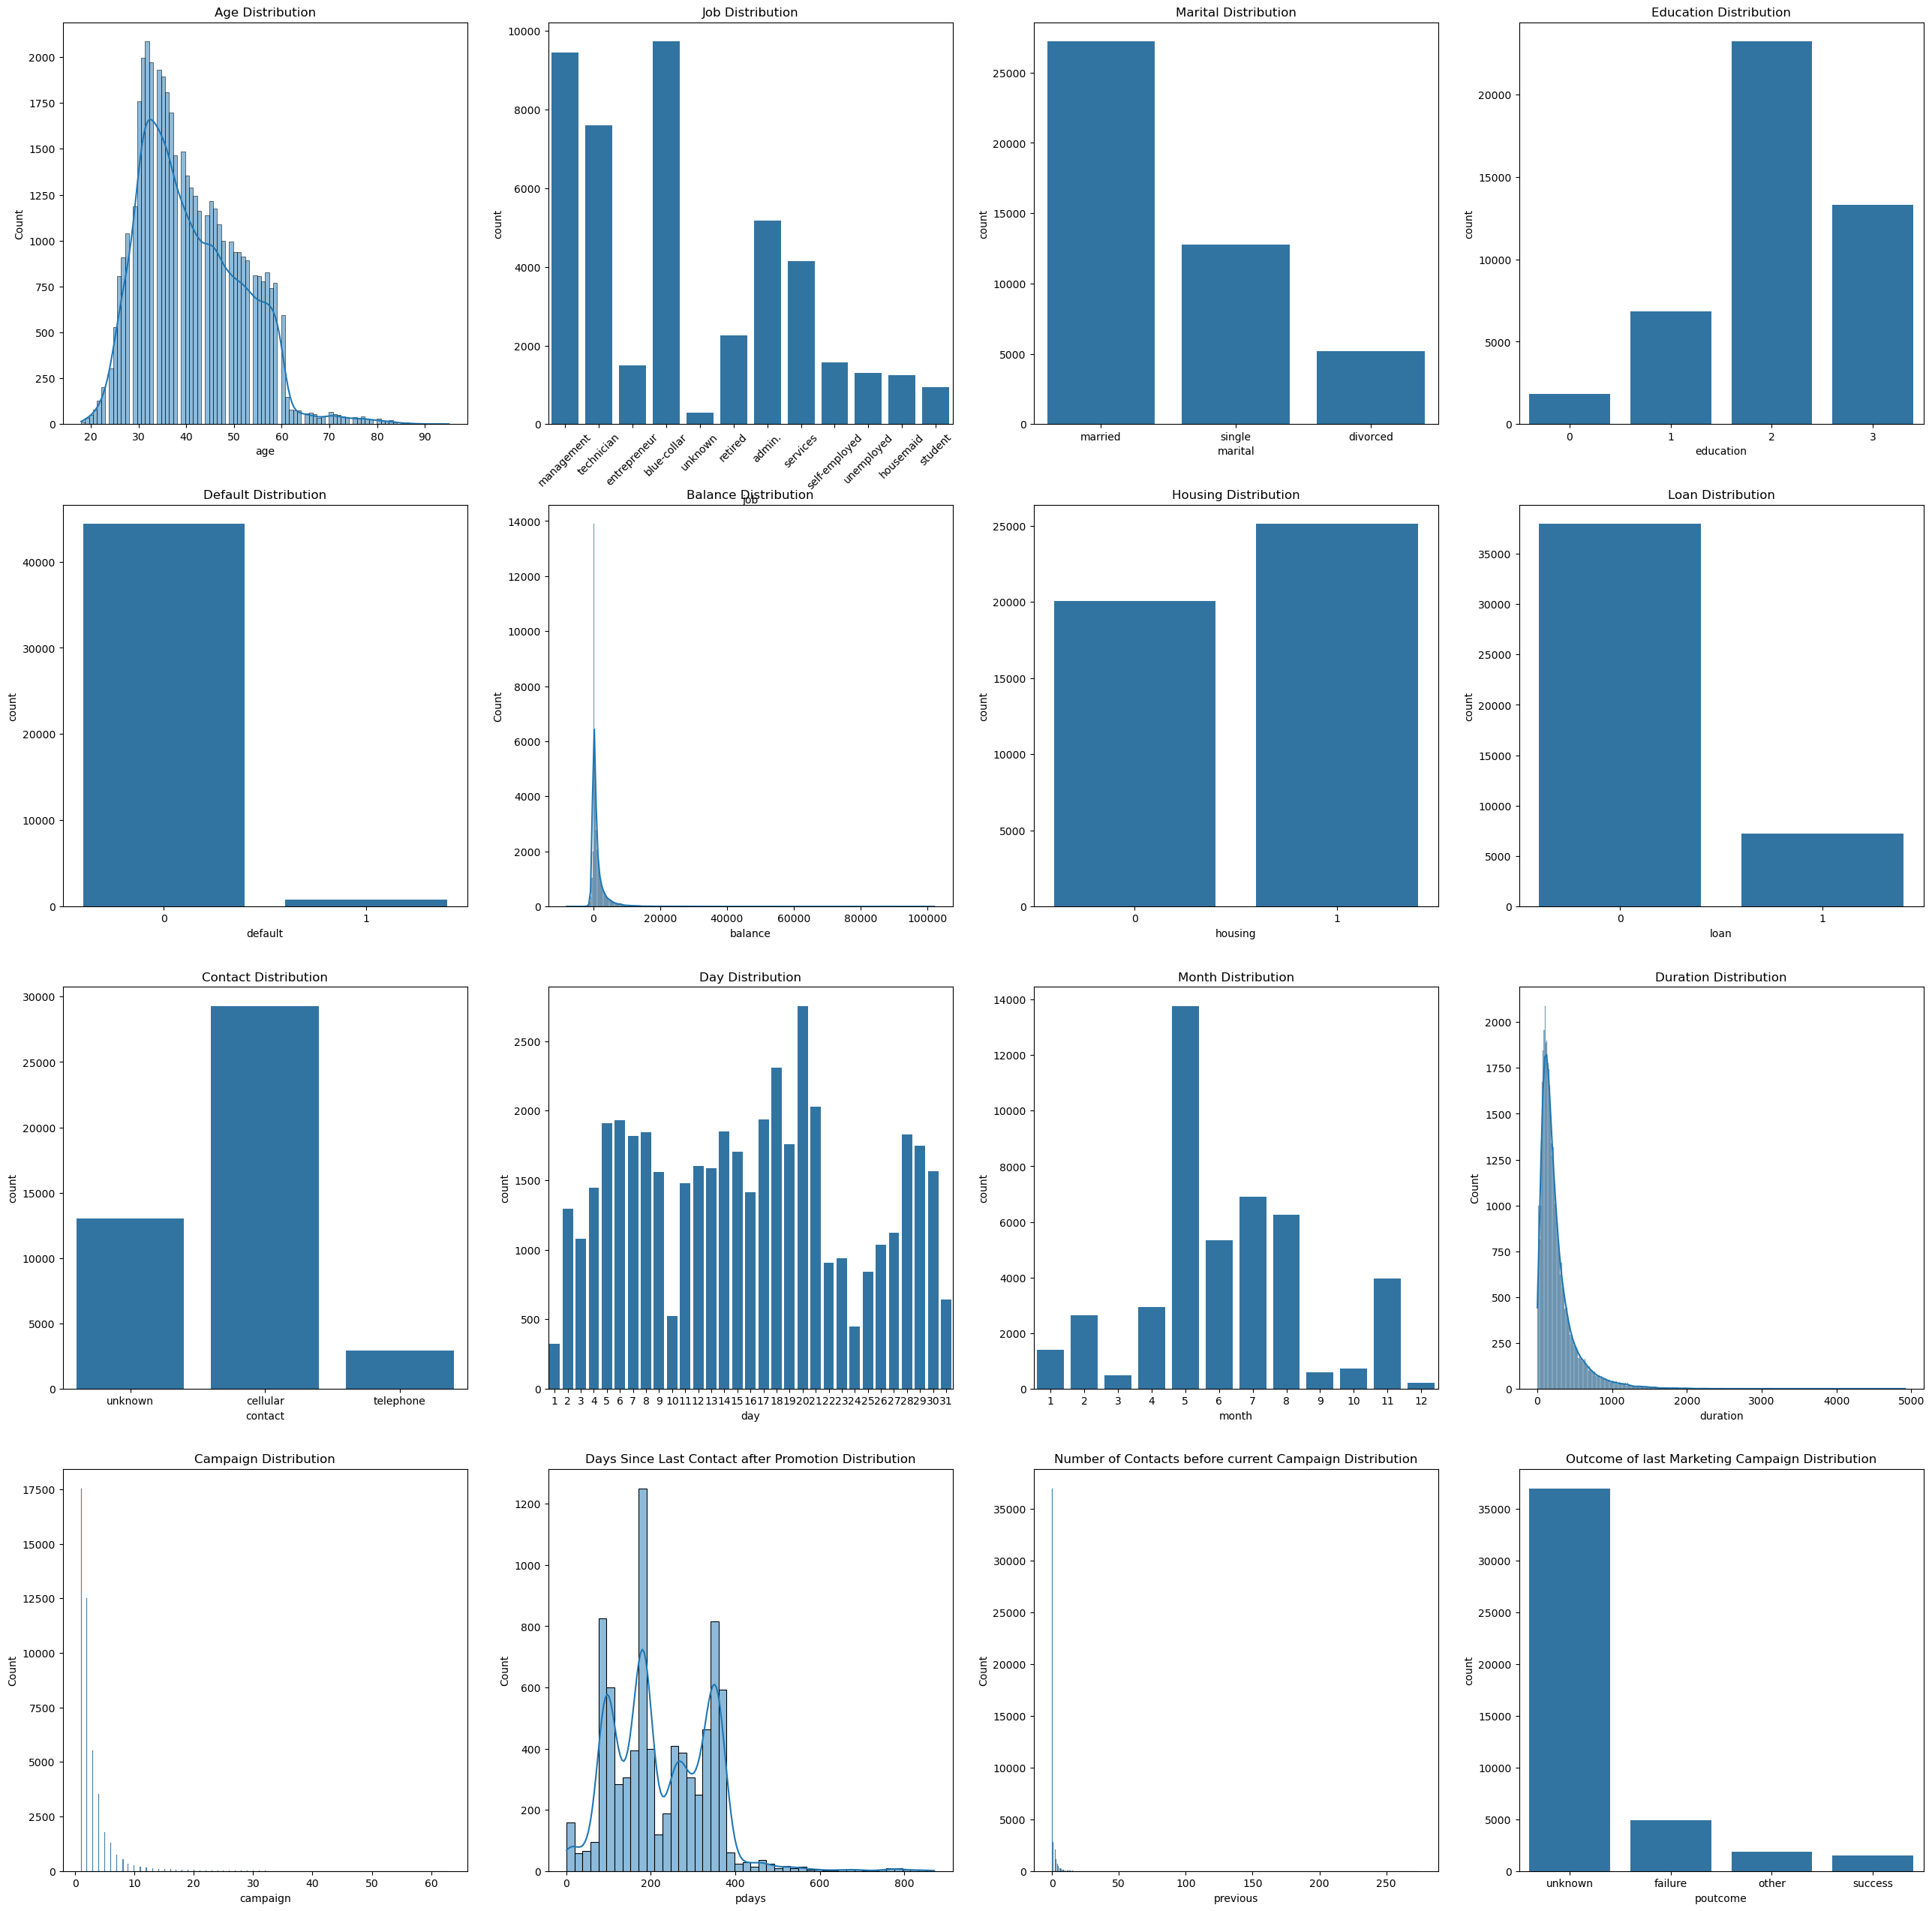

In [70]:
fig, axes = plt.subplots(4, 4, figsize=(32, 32))
sns.histplot(data=df, x='age', ax=axes[0,0], kde=True).set_title('Age Distribution')
sns.countplot(data=df, x='job', ax=axes[0,1]).set_title('Job Distribution') 
axes[0,1].tick_params(axis='x', rotation=45)
sns.countplot(data=df, x='marital', ax=axes[0,2]).set_title('Marital Distribution')
sns.countplot(data=df, x='education', ax=axes[0,3]).set_title('Education Distribution')
sns.countplot(data=df, x='default', ax=axes[1,0]).set_title('Default Distribution')
sns.histplot(data=df, x='balance', ax=axes[1,1], kde=True).set_title('Balance Distribution')
sns.countplot(data=df, x='housing', ax=axes[1,2]).set_title('Housing Distribution')
sns.countplot(data=df, x='loan', ax=axes[1,3]).set_title('Loan Distribution')
sns.countplot(data=df, x='contact', ax=axes[2,0]).set_title('Contact Distribution')
sns.countplot(data=df, x='day', ax=axes[2,1]).set_title('Day Distribution')
sns.countplot(data=df, x='month', ax=axes[2,2]).set_title('Month Distribution')
sns.histplot(data=df, x='duration', ax=axes[2,3], kde=True).set_title('Duration Distribution')
sns.histplot(data=df, x='campaign', ax=axes[3,0]).set_title('Campaign Distribution')
sns.histplot(data=df, x='pdays', ax=axes[3,1], kde=True).set_title('Days Since Last Contact after Promotion Distribution')
sns.histplot(data=df, x='previous', ax=axes[3,2]).set_title('Number of Contacts before current Campaign Distribution')
sns.countplot(data=df, x='poutcome', ax=axes[3,3]).set_title('Outcome of last Marketing Campaign Distribution')

In [21]:
x = df['balance']
c = np.median(np.abs(x))

df['balance_asinh'] = np.arcsinh(x / c)

In [22]:
x = df['balance']
x_shifted = x - x.min() + 1
x_log = np.log(x_shifted)

df['balance_log'] = x_log

In [23]:
df['balance_signedlog'] = np.sign(x) * np.log1p(np.abs(x))

In [24]:
x = df[['balance']]
pt = PowerTransformer(method='yeo-johnson')
pt.fit(x)
df['balance_trans'] = pt.transform(x)


<Axes: xlabel='balance_asinh', ylabel='Count'>

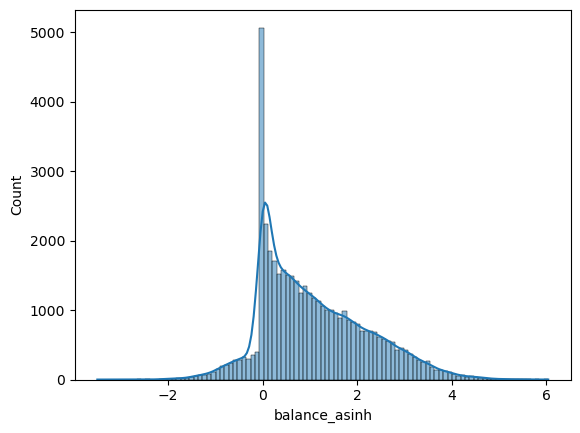

In [25]:
sns.histplot(data=df, x='balance_asinh', kde=True)

In [26]:
df.balance_asinh.describe()

count    45211.000000
mean         1.060763
std          1.128773
min         -3.499481
25%          0.147914
50%          0.826388
75%          1.800693
max          6.042976
Name: balance_asinh, dtype: float64

In [27]:
from scipy.stats.mstats import winsorize

x_win = winsorize(df['balance'], limits=[0, 0.001])
x_shifted = x_win - x_win.min() + 1
df['balance_log_winsor'] = np.log(x_shifted)

In [28]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'balance_asinh', 'balance_log',
       'balance_signedlog', 'balance_trans', 'balance_log_winsor'],
      dtype='object')

<Axes: xlabel='balance_trans', ylabel='Count'>

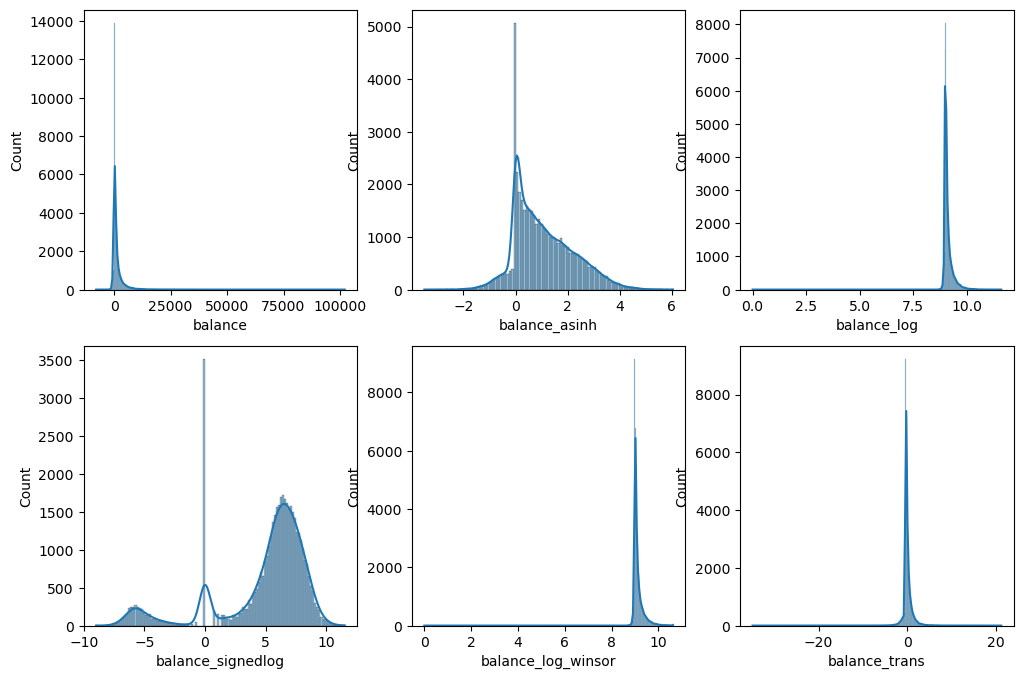

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
sns.histplot(data=df, x='balance', kde=True, ax=axes[0,0])
sns.histplot(data=df, x='balance_asinh', kde=True, ax=axes[0,1])
sns.histplot(data=df, x='balance_log', kde=True, ax=axes[0,2])
sns.histplot(data=df, x='balance_signedlog', kde=True, ax=axes[1,0])
sns.histplot(data=df, x='balance_log_winsor', kde=True, ax=axes[1,1])
sns.histplot(data=df, x='balance_trans', kde=True, ax=axes[1,2])

In [30]:
from scipy import stats
from sklearn.preprocessing import QuantileTransformer
x = df.balance
x_shifted = x - x.min() + 1.0
bc, _ = stats.boxcox(x_shifted)
df['boxcox_balance'] = bc

In [31]:
lam = 0.0
x_shifted = x - x.min() + 1.0
if lam == 0:
    transformed = np.log(x_shifted)
else:
    transformed = np.sign(x_shifted) * (np.abs(x_shifted) ** lam)

df['turkey_balance'] = transformed

In [32]:
x = df.balance

n_quantiles = min(1000, len(x))
a
qt = QuantileTransformer(
    n_quantiles=n_quantiles,
    output_distribution='normal',
    random_state=0
)

transformed = qt.fit_transform(x.values.reshape(-1, 1))
df['quantile_balance'] = transformed

<Axes: xlabel='quantile_balance', ylabel='Count'>

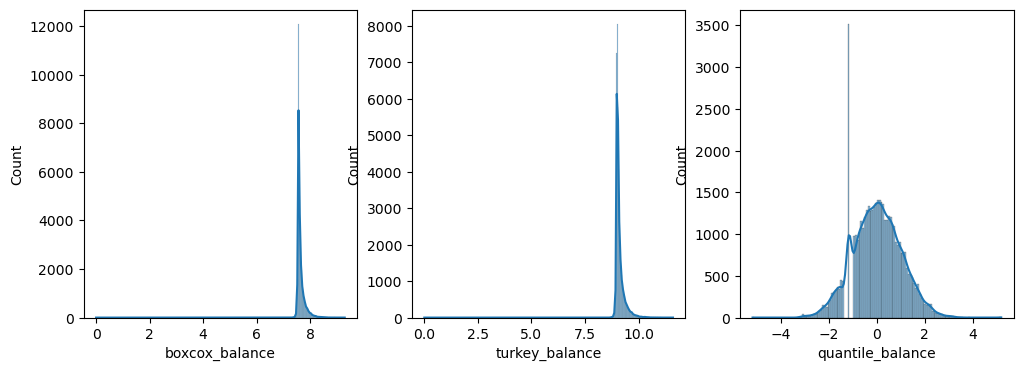

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(data=df, x='boxcox_balance', kde=True, ax=axes[0])
sns.histplot(data=df, x='turkey_balance', kde=True, ax=axes[1])
sns.histplot(data=df, x='quantile_balance', kde=True, ax=axes[2])

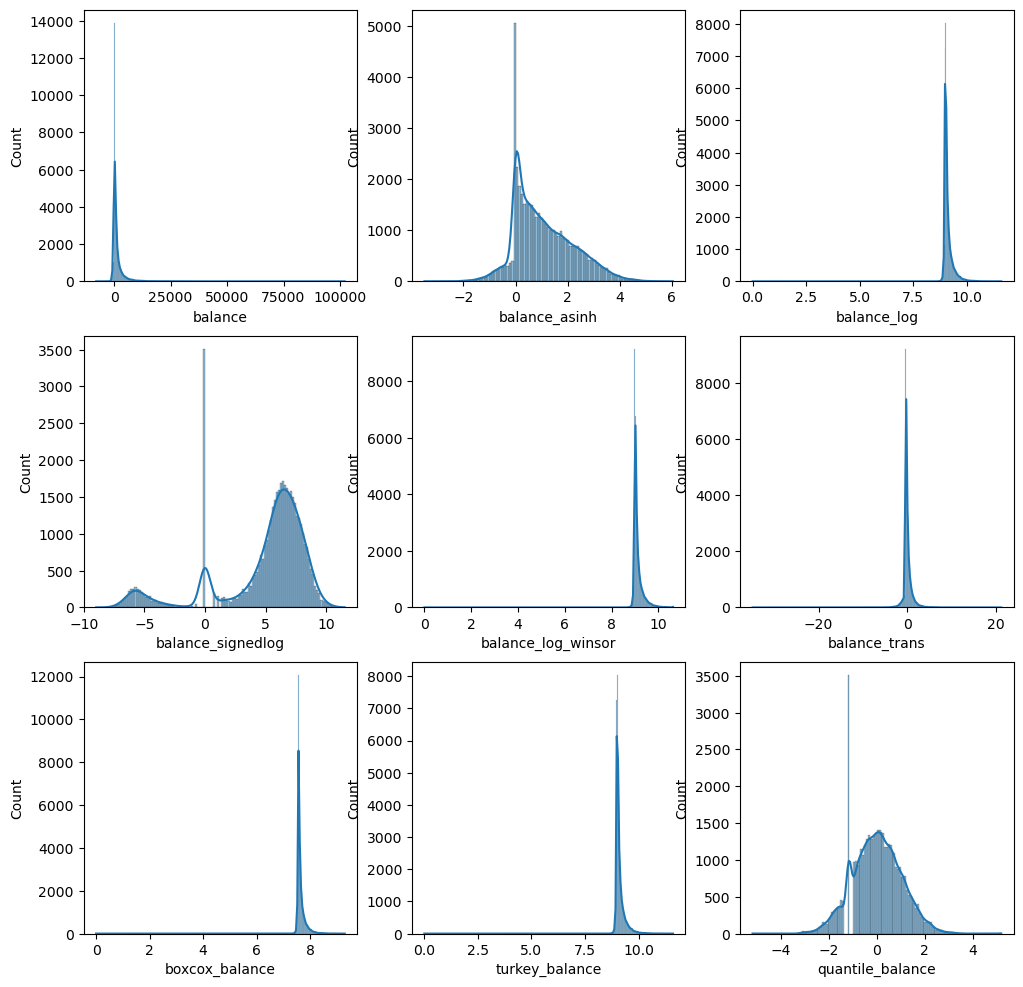

In [96]:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
sns.histplot(data=df, x='balance', kde=True, ax=axes[0,0])
sns.histplot(data=df, x='balance_asinh', kde=True, ax=axes[0,1])
sns.histplot(data=df, x='balance_log', kde=True, ax=axes[0,2])
sns.histplot(data=df, x='balance_signedlog', kde=True, ax=axes[1,0])
sns.histplot(data=df, x='balance_log_winsor', kde=True, ax=axes[1,1])
sns.histplot(data=df, x='balance_trans', kde=True, ax=axes[1,2])
sns.histplot(data=df, x='boxcox_balance', kde=True, ax=axes[2,0])
sns.histplot(data=df, x='turkey_balance', kde=True, ax=axes[2,1])
sns.histplot(data=df, x='quantile_balance', kde=True, ax=axes[2,2])
plt.savefig("balance_transform.png", dpi=100, bbox_inches="tight")

<Axes: xlabel='duration', ylabel='Count'>

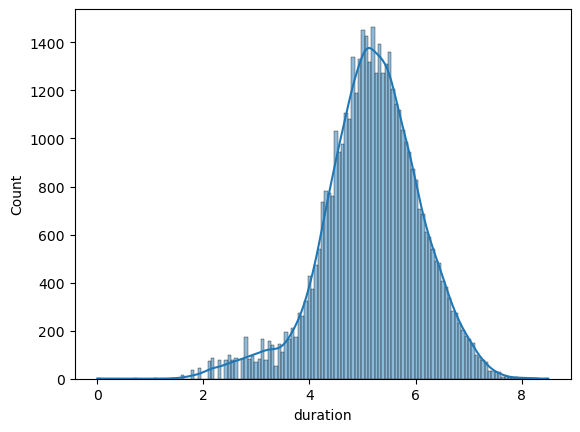

In [34]:
sns.histplot(data=df, x=np.log(df.duration + 1), kde=True)

In [35]:
df['duration_log'] = np.log(df.duration + 1)

<Axes: xlabel='age', ylabel='Count'>

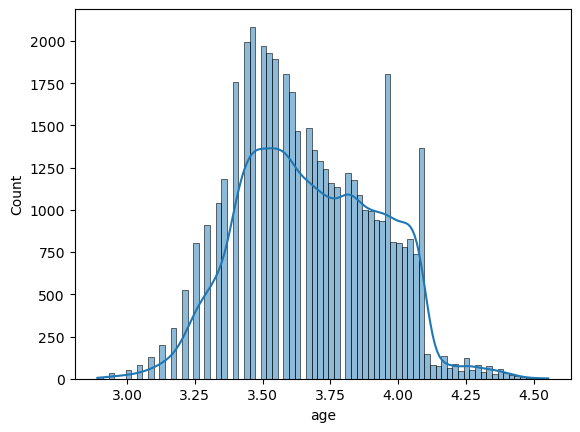

In [36]:
sns.histplot(data=df, x=np.log(df.age), kde=True)

In [37]:
df['age_log'] = np.log(df.age)

In [38]:
df['pdays'] = df['pdays'].replace(-1, np.nan)

In [39]:
df.pdays.describe()

count    8257.000000
mean      224.577692
std       115.344035
min         1.000000
25%       133.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

<Axes: xlabel='pdays', ylabel='Count'>

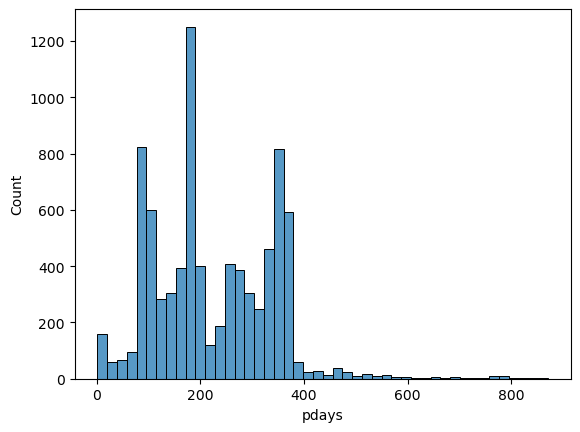

In [40]:
sns.histplot(data=df, x='pdays')

In [41]:
df.pdays.describe()

count    8257.000000
mean      224.577692
std       115.344035
min         1.000000
25%       133.000000
50%       194.000000
75%       327.000000
max       871.000000
Name: pdays, dtype: float64

In [42]:
df['pdays_cat'] = pd.cut(df['pdays'], bins=[0, 90, 180, 360, 900], labels=['<3mo','3-6mo','6-12mo','>12mo'])
df['pdays_cat'] = df['pdays_cat'].cat.add_categories('no_contact')
df['pdays_cat'] = df['pdays_cat'].fillna('no_contact')

<Axes: xlabel='pdays_cat', ylabel='count'>

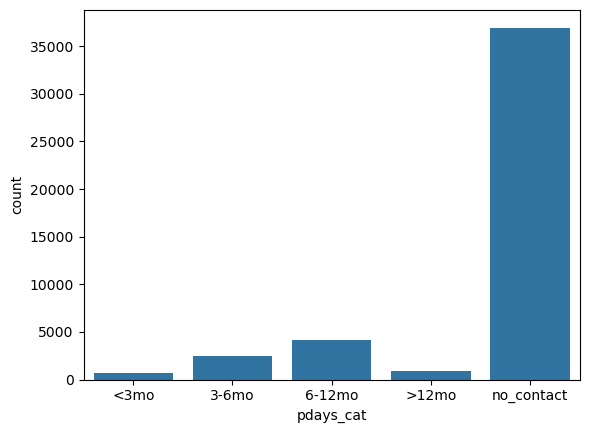

In [43]:
sns.countplot(data=df, x='pdays_cat')

<Axes: xlabel='previous', ylabel='Count'>

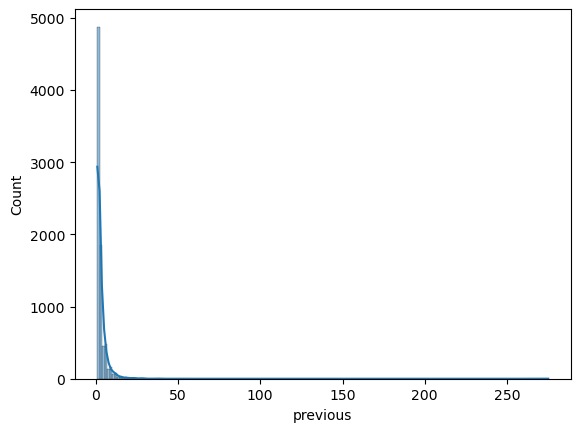

In [44]:
x = df[df['previous'] != 0]
sns.histplot(data=x, x='previous', kde=True)

In [45]:
df['ever_contacted'] = np.where(df['previous'] == 0, 0, 1)

<Axes: xlabel='ever_contacted', ylabel='count'>

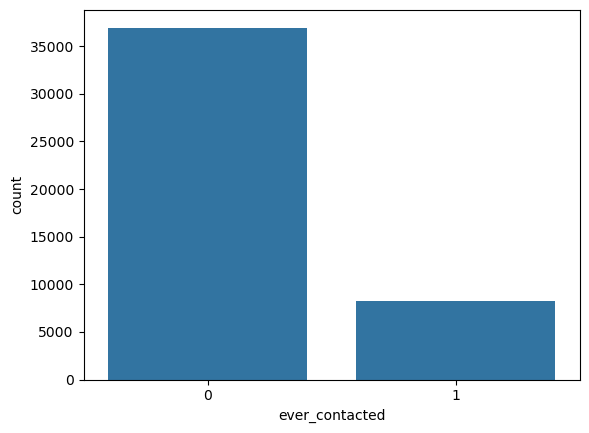

In [46]:
sns.countplot(data=df, x='ever_contacted')

In [47]:
df.campaign.describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

<Axes: xlabel='campaign', ylabel='Count'>

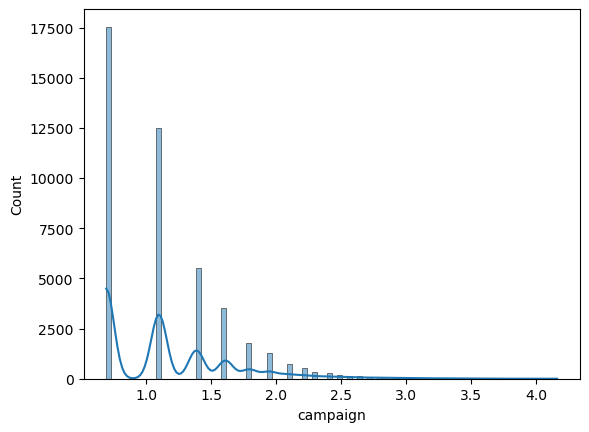

In [48]:
sns.histplot(data=df, x=np.log1p(df['campaign']), kde=True)

In [49]:
bins = [0, 1, 3, 5, 10, np.inf]
labels = ['1', '2-3', '4-5', '6-10', '10+']
df['campaign_bin'] = pd.cut(df['campaign'], bins=bins, labels=labels)

<Axes: xlabel='campaign_bin', ylabel='count'>

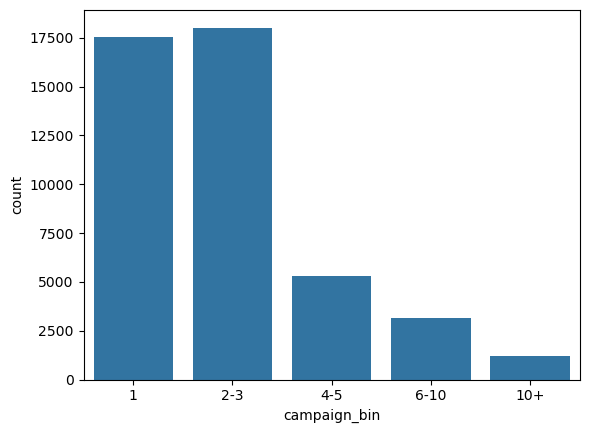

In [50]:
sns.countplot(data=df, x='campaign_bin')

In [51]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'balance_asinh', 'balance_log',
       'balance_signedlog', 'balance_trans', 'balance_log_winsor',
       'boxcox_balance', 'turkey_balance', 'quantile_balance', 'duration_log',
       'age_log', 'pdays_cat', 'ever_contacted', 'campaign_bin'],
      dtype='object')

## Data Preprocessing

In [52]:
X = df[['job', 'marital', 'education', 'default', 'housing', 'loan',
    'day', 'month', 'poutcome', 'quantile_balance', 'pdays_cat', 'ever_contacted',
    'campaign_bin', 'duration_log', 'age_log', 'contact']]
y = df.y
X.shape, y.shape

((45211, 16), (45211,))

In [53]:
X.head()

,job,marital,education,default,housing,loan,day,month,poutcome,quantile_balance,pdays_cat,ever_contacted,campaign_bin,duration_log,age_log,contact
0,management,married,3,0,1,0,5,5,unknown,0.948940,no_contact,0,1,5.568345,4.060443,unknown
1,technician,single,2,0,1,0,5,5,unknown,-0.826698,no_contact,0,1,5.023881,3.784190,unknown
2,entrepreneur,married,2,0,1,1,5,5,unknown,-0.975466,no_contact,0,1,4.343805,3.496508,unknown
3,blue-collar,married,0,0,1,0,5,5,unknown,0.716892,no_contact,0,1,4.532599,3.850148,unknown
4,unknown,single,0,0,0,0,5,5,unknown,-0.989697,no_contact,0,1,5.293305,3.496508,unknown


In [54]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   job               45211 non-null  object  
 1   marital           45211 non-null  object  
 2   education         45211 non-null  int64   
 3   default           45211 non-null  int64   
 4   housing           45211 non-null  int64   
 5   loan              45211 non-null  int64   
 6   day               45211 non-null  int64   
 7   month             45211 non-null  int64   
 8   poutcome          45211 non-null  object  
 9   quantile_balance  45211 non-null  float64 
 10  pdays_cat         45211 non-null  category
 11  ever_contacted    45211 non-null  int64   
 12  campaign_bin      45211 non-null  category
 13  duration_log      45211 non-null  float64 
 14  age_log           45211 non-null  float64 
 15  contact           45211 non-null  object  
dtypes: category(2), float6

In [55]:
cat_cols = ['job', 'marital', 'poutcome', 'pdays_cat', 'campaign_bin', 'contact']
num_cols = X.drop(columns=cat_cols).columns.tolist()

In [56]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            'cat',
            OneHotEncoder(
                handle_unknown='ignore',
                sparse_output=False
            ),
            cat_cols,
        ),
        (
            'num',
            StandardScaler(),
            num_cols,
        ),
    ],
    verbose_feature_names_out=True,
)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Modelling

In [64]:
def build_sampler(trial):
    strategy = trial.suggest_categorical(
        "sampling",
        ["none", "smote", "over", "under"]
    )

    if strategy == "smote":
        return SMOTE(random_state=42)
    if strategy == "over":
        return RandomOverSampler(random_state=42)
    if strategy == "under":
        return RandomUnderSampler(random_state=42)

    return None

In [65]:
def objective(trial, model_name, X, y):
    sampler = build_sampler(trial)

    use_class_weight = trial.suggest_categorical(
        "class_weight",
        [None, "balanced"]
    )

    if model_name == "lr":
        model = LogisticRegression(
            C=trial.suggest_float("C", 1e-3, 10, log=True),
            max_iter=1000,
            solver="lbfgs",
            class_weight=use_class_weight,
        )

    elif model_name == "tree":
        model = DecisionTreeClassifier(
            max_depth=trial.suggest_int("max_depth", 2, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 50),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
            class_weight=use_class_weight,
        )

    elif model_name == "rf":
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_split=trial.suggest_int("min_samples_split", 2, 50),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 20),
            n_jobs=-1,
            class_weight=use_class_weight,
        )

    elif model_name == "xgb":
        scale_pos_weight = trial.suggest_float("scale_pos_weight", 0.5, 10)

        model = XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 500),
            max_depth=trial.suggest_int("max_depth", 3, 10),
            learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
            subsample=trial.suggest_float("subsample", 0.6, 1.0),
            colsample_bytree=trial.suggest_float("colsample_bytree", 0.6, 1.0),
            scale_pos_weight=scale_pos_weight,
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1,
        )

    steps = [("preprocess", preprocessor)]

    if sampler is not None:
        steps.append(("sampler", sampler))

    steps.append(("model", model))

    pipeline = ImbPipeline(steps)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    score = cross_val_score(
        pipeline,
        X,
        y,
        cv=cv,
        scoring="roc_auc",
        n_jobs=-1,
    ).mean()

    return score

In [66]:
def tune_model(model_name, X, y, n_trials=50):
    study = optuna.create_study(direction='maximize')
    study.optimize(
        lambda trial: objective(trial, model_name, X, y),
        n_trials=n_trials,
        show_progress_bar=True,
    )
    return study

In [67]:
models = ["lr", "tree", "rf", "xgb"]
results = {}

In [73]:
for model_name in models:
    study = tune_model(model_name, X_train, y_train, n_trials=50)

    results[model_name] = {
        "best_value": study.best_value,
        "best_params": study.best_params,
        "study": study,
        "sampling_table": sampling_performance_table(study),
    }

[I 2026-01-08 11:59:00,842] A new study created in memory with name: no-name-1846aecc-fc27-464b-8ca2-86aa140b7761
Best trial: 0. Best value: 0.894399:   2%|▉                                             | 1/50 [00:07<05:45,  7.06s/it]

[I 2026-01-08 11:59:07,897] Trial 0 finished with value: 0.8943985833703205 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'C': 0.12873436213015546}. Best is trial 0 with value: 0.8943985833703205.


Best trial: 0. Best value: 0.894399:   4%|█▊                                            | 2/50 [00:11<04:25,  5.54s/it]

[I 2026-01-08 11:59:12,367] Trial 1 finished with value: 0.8934870996214486 and parameters: {'sampling': 'smote', 'class_weight': None, 'C': 0.713589759265617}. Best is trial 0 with value: 0.8943985833703205.


Best trial: 2. Best value: 0.894448:   6%|██▊                                           | 3/50 [00:15<03:51,  4.92s/it]

[I 2026-01-08 11:59:16,538] Trial 2 finished with value: 0.8944484824786105 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 4.210862214820546}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 2. Best value: 0.894448:   8%|███▋                                          | 4/50 [00:20<03:35,  4.68s/it]

[I 2026-01-08 11:59:20,875] Trial 3 finished with value: 0.8940800724533409 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'C': 0.19345225866194216}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 2. Best value: 0.894448:  10%|████▌                                         | 5/50 [00:24<03:25,  4.56s/it]

[I 2026-01-08 11:59:25,223] Trial 4 finished with value: 0.8938926914492381 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'C': 1.4364616277480073}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 2. Best value: 0.894448:  12%|█████▌                                        | 6/50 [00:29<03:22,  4.60s/it]

[I 2026-01-08 11:59:29,914] Trial 5 finished with value: 0.8943300747047778 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'C': 0.060881747013641165}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 2. Best value: 0.894448:  14%|██████▍                                       | 7/50 [00:33<03:22,  4.70s/it]

[I 2026-01-08 11:59:34,813] Trial 6 finished with value: 0.8856802131150087 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'C': 0.0030891411420759015}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 2. Best value: 0.894448:  16%|███████▎                                      | 8/50 [00:34<02:20,  3.35s/it]

[I 2026-01-08 11:59:35,269] Trial 7 finished with value: 0.8908103996713667 and parameters: {'sampling': 'none', 'class_weight': None, 'C': 0.005330103596915159}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 2. Best value: 0.894448:  18%|████████▎                                     | 9/50 [00:35<01:45,  2.57s/it]

[I 2026-01-08 11:59:36,121] Trial 8 finished with value: 0.8943571015670037 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'C': 0.02231251797721934}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 2. Best value: 0.894448:  20%|█████████                                    | 10/50 [00:35<01:18,  1.96s/it]

[I 2026-01-08 11:59:36,698] Trial 9 finished with value: 0.8918366722174118 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.0025193311380638252}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 2. Best value: 0.894448:  22%|█████████▉                                   | 11/50 [00:36<01:01,  1.58s/it]

[I 2026-01-08 11:59:37,415] Trial 10 finished with value: 0.8944458648125597 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 5.412819035328332}. Best is trial 2 with value: 0.8944484824786105.


Best trial: 11. Best value: 0.894448:  24%|██████████▌                                 | 12/50 [00:37<00:50,  1.34s/it]

[I 2026-01-08 11:59:38,221] Trial 11 finished with value: 0.894448482653131 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 9.569173976473666}. Best is trial 11 with value: 0.894448482653131.


Best trial: 11. Best value: 0.894448:  26%|███████████▍                                | 13/50 [00:38<00:42,  1.15s/it]

[I 2026-01-08 11:59:38,948] Trial 12 finished with value: 0.89444843424748 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 9.606856385137098}. Best is trial 11 with value: 0.894448482653131.


Best trial: 11. Best value: 0.894448:  28%|████████████▎                               | 14/50 [00:38<00:38,  1.07s/it]

[I 2026-01-08 11:59:39,828] Trial 13 finished with value: 0.8944483862489534 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 1.5794162229741404}. Best is trial 11 with value: 0.894448482653131.


Best trial: 11. Best value: 0.894448:  30%|█████████████▏                              | 15/50 [00:39<00:35,  1.02s/it]

[I 2026-01-08 11:59:40,735] Trial 14 finished with value: 0.8934700913681745 and parameters: {'sampling': 'smote', 'class_weight': None, 'C': 3.4971064999348624}. Best is trial 11 with value: 0.894448482653131.


Best trial: 15. Best value: 0.894459:  32%|██████████████                              | 16/50 [00:40<00:32,  1.05it/s]

[I 2026-01-08 11:59:41,537] Trial 15 finished with value: 0.8944589535889852 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.42959773904303233}. Best is trial 15 with value: 0.8944589535889852.


Best trial: 16. Best value: 0.89446:  34%|███████████████▎                             | 17/50 [00:41<00:29,  1.13it/s]

[I 2026-01-08 11:59:42,257] Trial 16 finished with value: 0.8944595350520244 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.4446951148971486}. Best is trial 16 with value: 0.8944595350520244.


Best trial: 16. Best value: 0.89446:  36%|████████████████▏                            | 18/50 [00:42<00:25,  1.24it/s]

[I 2026-01-08 11:59:42,889] Trial 17 finished with value: 0.8944592927403191 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.39879081292450347}. Best is trial 16 with value: 0.8944595350520244.


Best trial: 16. Best value: 0.89446:  38%|█████████████████                            | 19/50 [00:43<00:29,  1.04it/s]

[I 2026-01-08 11:59:44,218] Trial 18 finished with value: 0.8936604619929233 and parameters: {'sampling': 'smote', 'class_weight': None, 'C': 0.03674646128758304}. Best is trial 16 with value: 0.8944595350520244.


Best trial: 19. Best value: 0.894463:  40%|█████████████████▌                          | 20/50 [00:43<00:25,  1.17it/s]

[I 2026-01-08 11:59:44,800] Trial 19 finished with value: 0.8944627837523773 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.33693468006587324}. Best is trial 19 with value: 0.8944627837523773.


Best trial: 19. Best value: 0.894463:  42%|██████████████████▍                         | 21/50 [00:44<00:23,  1.22it/s]

[I 2026-01-08 11:59:45,543] Trial 20 finished with value: 0.893905788159042 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.009078165279048188}. Best is trial 19 with value: 0.8944627837523773.


Best trial: 19. Best value: 0.894463:  44%|███████████████████▎                        | 22/50 [00:45<00:21,  1.27it/s]

[I 2026-01-08 11:59:46,247] Trial 21 finished with value: 0.8944579363907301 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.35871500498053105}. Best is trial 19 with value: 0.8944627837523773.


Best trial: 22. Best value: 0.894469:  46%|████████████████████▏                       | 23/50 [00:46<00:20,  1.29it/s]

[I 2026-01-08 11:59:47,006] Trial 22 finished with value: 0.8944687399705428 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.24487376038827874}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  48%|█████████████████████                       | 24/50 [00:46<00:19,  1.33it/s]

[I 2026-01-08 11:59:47,702] Trial 23 finished with value: 0.8944648622342456 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.17395013902211612}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  50%|██████████████████████                      | 25/50 [00:47<00:18,  1.36it/s]

[I 2026-01-08 11:59:48,395] Trial 24 finished with value: 0.8944603076992136 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.09834373674979842}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  52%|██████████████████████▉                     | 26/50 [00:48<00:17,  1.40it/s]

[I 2026-01-08 11:59:49,058] Trial 25 finished with value: 0.8944666565373213 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.1943029859192444}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  54%|███████████████████████▊                    | 27/50 [00:49<00:18,  1.22it/s]

[I 2026-01-08 11:59:50,130] Trial 26 finished with value: 0.8936764961512758 and parameters: {'sampling': 'smote', 'class_weight': None, 'C': 0.019550288874000753}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  56%|████████████████████████▋                   | 28/50 [00:49<00:15,  1.42it/s]

[I 2026-01-08 11:59:50,564] Trial 27 finished with value: 0.8938085887806796 and parameters: {'sampling': 'under', 'class_weight': None, 'C': 0.05963565316514567}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  58%|█████████████████████████▌                  | 29/50 [00:50<00:14,  1.47it/s]

[I 2026-01-08 11:59:51,198] Trial 28 finished with value: 0.8894077101604496 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.001143323562143585}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  60%|██████████████████████████▍                 | 30/50 [00:50<00:12,  1.58it/s]

[I 2026-01-08 11:59:51,712] Trial 29 finished with value: 0.8943983895368234 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'C': 0.14656977870059001}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  62%|███████████████████████████▎                | 31/50 [00:51<00:11,  1.61it/s]

[I 2026-01-08 11:59:52,308] Trial 30 finished with value: 0.8942135373545466 and parameters: {'sampling': 'none', 'class_weight': None, 'C': 0.18519365030982085}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  64%|████████████████████████████▏               | 32/50 [00:52<00:11,  1.50it/s]

[I 2026-01-08 11:59:53,079] Trial 31 finished with value: 0.894448240712717 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 1.565809862749204}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  66%|█████████████████████████████               | 33/50 [00:52<00:11,  1.52it/s]

[I 2026-01-08 11:59:53,705] Trial 32 finished with value: 0.894453476317009 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.7809712400149685}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  68%|█████████████████████████████▉              | 34/50 [00:53<00:10,  1.47it/s]

[I 2026-01-08 11:59:54,444] Trial 33 finished with value: 0.8944582251538776 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.08551769623249943}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  70%|██████████████████████████████▊             | 35/50 [00:54<00:10,  1.41it/s]

[I 2026-01-08 11:59:55,215] Trial 34 finished with value: 0.8944591940967811 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.22769012207958617}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  72%|███████████████████████████████▋            | 36/50 [00:55<00:12,  1.11it/s]

[I 2026-01-08 11:59:56,563] Trial 35 finished with value: 0.8934820605344023 and parameters: {'sampling': 'smote', 'class_weight': None, 'C': 0.908330266052446}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  74%|████████████████████████████████▌           | 37/50 [00:56<00:09,  1.33it/s]

[I 2026-01-08 11:59:56,973] Trial 36 finished with value: 0.894025015589141 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'C': 0.3006108417961541}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  76%|█████████████████████████████████▍          | 38/50 [00:56<00:08,  1.38it/s]

[I 2026-01-08 11:59:57,634] Trial 37 finished with value: 0.8944639890110206 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.13655972059815932}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  78%|██████████████████████████████████▎         | 39/50 [00:57<00:08,  1.29it/s]

[I 2026-01-08 11:59:58,513] Trial 38 finished with value: 0.8944512387947479 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'C': 0.04410345450136907}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  80%|███████████████████████████████████▏        | 40/50 [00:58<00:07,  1.35it/s]

[I 2026-01-08 11:59:59,181] Trial 39 finished with value: 0.8941946134577362 and parameters: {'sampling': 'none', 'class_weight': None, 'C': 0.1271908152985179}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  82%|████████████████████████████████████        | 41/50 [00:58<00:05,  1.61it/s]

[I 2026-01-08 11:59:59,515] Trial 40 finished with value: 0.8919961759208738 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'C': 0.018120306300503344}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  84%|████████████████████████████████████▉       | 42/50 [00:59<00:05,  1.55it/s]

[I 2026-01-08 12:00:00,221] Trial 41 finished with value: 0.8944590484813719 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.23163311985535967}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 22. Best value: 0.894469:  86%|█████████████████████████████████████▊      | 43/50 [01:00<00:04,  1.49it/s]

[I 2026-01-08 12:00:00,949] Trial 42 finished with value: 0.8944563852658863 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.7038948367958999}. Best is trial 22 with value: 0.8944687399705428.


Best trial: 43. Best value: 0.89447:  88%|███████████████████████████████████████▌     | 44/50 [01:00<00:04,  1.45it/s]

[I 2026-01-08 12:00:01,686] Trial 43 finished with value: 0.8944702930921494 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.07535259738804785}. Best is trial 43 with value: 0.8944702930921494.


Best trial: 43. Best value: 0.89447:  90%|████████████████████████████████████████▌    | 45/50 [01:01<00:03,  1.39it/s]

[I 2026-01-08 12:00:02,481] Trial 44 finished with value: 0.8944561899990676 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.06730164415485385}. Best is trial 43 with value: 0.8944702930921494.


Best trial: 43. Best value: 0.89447:  92%|█████████████████████████████████████████▍   | 46/50 [01:02<00:03,  1.30it/s]

[I 2026-01-08 12:00:03,365] Trial 45 finished with value: 0.8944342316602623 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.04002676124024931}. Best is trial 43 with value: 0.8944702930921494.


Best trial: 43. Best value: 0.89447:  94%|██████████████████████████████████████████▎  | 47/50 [01:03<00:02,  1.36it/s]

[I 2026-01-08 12:00:04,025] Trial 46 finished with value: 0.8944677681676694 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.1335079391951551}. Best is trial 43 with value: 0.8944702930921494.


Best trial: 43. Best value: 0.89447:  96%|███████████████████████████████████████████▏ | 48/50 [01:03<00:01,  1.33it/s]

[I 2026-01-08 12:00:04,810] Trial 47 finished with value: 0.8944597262546716 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.0979370689677143}. Best is trial 43 with value: 0.8944702930921494.


Best trial: 43. Best value: 0.89447:  98%|████████████████████████████████████████████ | 49/50 [01:04<00:00,  1.31it/s]

[I 2026-01-08 12:00:05,603] Trial 48 finished with value: 0.8944203847947527 and parameters: {'sampling': 'over', 'class_weight': None, 'C': 0.03232742690623335}. Best is trial 43 with value: 0.8944702930921494.


Best trial: 43. Best value: 0.89447: 100%|█████████████████████████████████████████████| 50/50 [01:05<00:00,  1.31s/it]
[I 2026-01-08 12:00:06,141] A new study created in memory with name: no-name-a5811285-e383-4151-9e2e-a1ed76d7626e


[I 2026-01-08 12:00:06,114] Trial 49 finished with value: 0.8935503711558244 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'C': 0.012197103093548368}. Best is trial 43 with value: 0.8944702930921494.


Best trial: 0. Best value: 0.888051:   2%|▉                                             | 1/50 [00:00<00:35,  1.37it/s]

[I 2026-01-08 12:00:06,866] Trial 0 finished with value: 0.8880512853902414 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'max_depth': 9, 'min_samples_split': 38, 'min_samples_leaf': 16}. Best is trial 0 with value: 0.8880512853902414.


Best trial: 1. Best value: 0.891809:   4%|█▊                                            | 2/50 [00:01<00:33,  1.42it/s]

[I 2026-01-08 12:00:07,556] Trial 1 finished with value: 0.8918088870652963 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'max_depth': 8, 'min_samples_split': 45, 'min_samples_leaf': 20}. Best is trial 1 with value: 0.8918088870652963.


Best trial: 1. Best value: 0.891809:   6%|██▊                                           | 3/50 [00:02<00:35,  1.34it/s]

[I 2026-01-08 12:00:08,355] Trial 2 finished with value: 0.817986841585278 and parameters: {'sampling': 'over', 'class_weight': None, 'max_depth': 14, 'min_samples_split': 31, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8918088870652963.


Best trial: 1. Best value: 0.891809:   8%|███▋                                          | 4/50 [00:02<00:28,  1.59it/s]

[I 2026-01-08 12:00:08,796] Trial 3 finished with value: 0.8721168490850554 and parameters: {'sampling': 'under', 'class_weight': None, 'max_depth': 17, 'min_samples_split': 15, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8918088870652963.


Best trial: 1. Best value: 0.891809:  10%|████▌                                         | 5/50 [00:03<00:25,  1.79it/s]

[I 2026-01-08 12:00:09,234] Trial 4 finished with value: 0.8884341813840632 and parameters: {'sampling': 'under', 'class_weight': None, 'max_depth': 18, 'min_samples_split': 33, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8918088870652963.


Best trial: 1. Best value: 0.891809:  12%|█████▌                                        | 6/50 [00:03<00:23,  1.86it/s]

[I 2026-01-08 12:00:09,715] Trial 5 finished with value: 0.8617808836690921 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 5, 'min_samples_split': 40, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8918088870652963.


Best trial: 1. Best value: 0.891809:  14%|██████▍                                       | 7/50 [00:04<00:28,  1.52it/s]

[I 2026-01-08 12:00:10,632] Trial 6 finished with value: 0.8058374196296926 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'max_depth': 16, 'min_samples_split': 21, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8918088870652963.


Best trial: 1. Best value: 0.891809:  16%|███████▎                                      | 8/50 [00:04<00:24,  1.69it/s]

[I 2026-01-08 12:00:11,087] Trial 7 finished with value: 0.8383602087721336 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'max_depth': 3, 'min_samples_split': 35, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.8918088870652963.


Best trial: 1. Best value: 0.891809:  18%|████████▎                                     | 9/50 [00:05<00:23,  1.76it/s]

[I 2026-01-08 12:00:11,606] Trial 8 finished with value: 0.86311898550754 and parameters: {'sampling': 'over', 'class_weight': None, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 17}. Best is trial 1 with value: 0.8918088870652963.


Best trial: 9. Best value: 0.894278:  20%|█████████                                    | 10/50 [00:05<00:19,  2.05it/s]

[I 2026-01-08 12:00:11,906] Trial 9 finished with value: 0.8942777269325111 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'max_depth': 14, 'min_samples_split': 50, 'min_samples_leaf': 16}. Best is trial 9 with value: 0.8942777269325111.


Best trial: 10. Best value: 0.895277:  22%|█████████▋                                  | 11/50 [00:07<00:30,  1.29it/s]

[I 2026-01-08 12:00:13,334] Trial 10 finished with value: 0.8952765588247218 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 12, 'min_samples_split': 46, 'min_samples_leaf': 12}. Best is trial 10 with value: 0.8952765588247218.


Best trial: 10. Best value: 0.895277:  24%|██████████▌                                 | 12/50 [00:08<00:36,  1.05it/s]

[I 2026-01-08 12:00:14,703] Trial 11 finished with value: 0.8949306859233008 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 13, 'min_samples_split': 50, 'min_samples_leaf': 12}. Best is trial 10 with value: 0.8952765588247218.


Best trial: 12. Best value: 0.896054:  26%|███████████▍                                | 13/50 [00:09<00:40,  1.08s/it]

[I 2026-01-08 12:00:16,069] Trial 12 finished with value: 0.8960541888825413 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 12, 'min_samples_split': 50, 'min_samples_leaf': 12}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  28%|████████████▎                               | 14/50 [00:11<00:41,  1.16s/it]

[I 2026-01-08 12:00:17,414] Trial 13 finished with value: 0.8953402964581242 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 43, 'min_samples_leaf': 11}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  30%|█████████████▏                              | 15/50 [00:12<00:39,  1.11s/it]

[I 2026-01-08 12:00:18,415] Trial 14 finished with value: 0.8910876883497204 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 9, 'min_samples_split': 24, 'min_samples_leaf': 9}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  32%|██████████████                              | 16/50 [00:13<00:39,  1.15s/it]

[I 2026-01-08 12:00:19,660] Trial 15 finished with value: 0.8904023393914828 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 42, 'min_samples_leaf': 13}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  34%|██████████████▉                             | 17/50 [00:14<00:37,  1.12s/it]

[I 2026-01-08 12:00:20,716] Trial 16 finished with value: 0.8865284595777295 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 6, 'min_samples_split': 28, 'min_samples_leaf': 8}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  36%|███████████████▊                            | 18/50 [00:15<00:36,  1.15s/it]

[I 2026-01-08 12:00:21,919] Trial 17 finished with value: 0.8854682938970546 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 11, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  38%|████████████████▋                           | 19/50 [00:16<00:33,  1.08s/it]

[I 2026-01-08 12:00:22,860] Trial 18 finished with value: 0.8907471542175915 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 7, 'min_samples_split': 46, 'min_samples_leaf': 6}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  40%|█████████████████▌                          | 20/50 [00:17<00:32,  1.08s/it]

[I 2026-01-08 12:00:23,919] Trial 19 finished with value: 0.8948054025457045 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 38, 'min_samples_leaf': 13}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  42%|██████████████████▍                         | 21/50 [00:18<00:26,  1.09it/s]

[I 2026-01-08 12:00:24,452] Trial 20 finished with value: 0.8782945135817559 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 14}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  44%|███████████████████▎                        | 22/50 [00:19<00:28,  1.01s/it]

[I 2026-01-08 12:00:25,673] Trial 21 finished with value: 0.8942184171500639 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 12, 'min_samples_split': 45, 'min_samples_leaf': 11}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  46%|████████████████████▏                       | 23/50 [00:20<00:28,  1.07s/it]

[I 2026-01-08 12:00:26,899] Trial 22 finished with value: 0.8948430448309985 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 50, 'min_samples_leaf': 10}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  48%|█████████████████████                       | 24/50 [00:21<00:28,  1.11s/it]

[I 2026-01-08 12:00:28,092] Trial 23 finished with value: 0.8943533513700496 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 12, 'min_samples_split': 43, 'min_samples_leaf': 14}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  50%|██████████████████████                      | 25/50 [00:23<00:27,  1.10s/it]

[I 2026-01-08 12:00:29,139] Trial 24 finished with value: 0.8934416628760837 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 47, 'min_samples_leaf': 7}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  52%|██████████████████████▉                     | 26/50 [00:24<00:27,  1.13s/it]

[I 2026-01-08 12:00:30,361] Trial 25 finished with value: 0.8914773878959423 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 13, 'min_samples_split': 36, 'min_samples_leaf': 11}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  54%|███████████████████████▊                    | 27/50 [00:25<00:24,  1.09s/it]

[I 2026-01-08 12:00:31,352] Trial 26 finished with value: 0.8941738392595988 and parameters: {'sampling': 'smote', 'class_weight': None, 'max_depth': 8, 'min_samples_split': 41, 'min_samples_leaf': 20}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  56%|████████████████████████▋                   | 28/50 [00:26<00:24,  1.12s/it]

[I 2026-01-08 12:00:32,545] Trial 27 finished with value: 0.8955657516256229 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 12, 'min_samples_split': 47, 'min_samples_leaf': 18}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  58%|█████████████████████████▌                  | 29/50 [00:26<00:18,  1.12it/s]

[I 2026-01-08 12:00:32,898] Trial 28 finished with value: 0.7948568573396757 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'max_depth': 2, 'min_samples_split': 29, 'min_samples_leaf': 18}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  60%|██████████████████████████▍                 | 30/50 [00:27<00:15,  1.33it/s]

[I 2026-01-08 12:00:33,331] Trial 29 finished with value: 0.8914578921781858 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'max_depth': 9, 'min_samples_split': 38, 'min_samples_leaf': 18}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  62%|███████████████████████████▎                | 31/50 [00:28<00:16,  1.17it/s]

[I 2026-01-08 12:00:34,425] Trial 30 finished with value: 0.8960334015952363 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 48, 'min_samples_leaf': 15}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  64%|████████████████████████████▏               | 32/50 [00:29<00:16,  1.10it/s]

[I 2026-01-08 12:00:35,465] Trial 31 finished with value: 0.8960047425684905 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 48, 'min_samples_leaf': 15}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  66%|█████████████████████████████               | 33/50 [00:30<00:16,  1.04it/s]

[I 2026-01-08 12:00:36,552] Trial 32 finished with value: 0.8941711436054225 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 8, 'min_samples_split': 47, 'min_samples_leaf': 15}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  68%|█████████████████████████████▉              | 34/50 [00:31<00:16,  1.03s/it]

[I 2026-01-08 12:00:37,747] Trial 33 finished with value: 0.8950399455267979 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 11, 'min_samples_split': 48, 'min_samples_leaf': 18}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  70%|██████████████████████████████▊             | 35/50 [00:32<00:14,  1.01it/s]

[I 2026-01-08 12:00:38,639] Trial 34 finished with value: 0.8737414571301949 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'max_depth': 14, 'min_samples_split': 44, 'min_samples_leaf': 15}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  72%|███████████████████████████████▋            | 36/50 [00:33<00:13,  1.03it/s]

[I 2026-01-08 12:00:39,570] Trial 35 finished with value: 0.8904533135017314 and parameters: {'sampling': 'smote', 'class_weight': None, 'max_depth': 7, 'min_samples_split': 39, 'min_samples_leaf': 19}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  74%|████████████████████████████████▌           | 37/50 [00:33<00:10,  1.22it/s]

[I 2026-01-08 12:00:40,045] Trial 36 finished with value: 0.894525618177618 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'max_depth': 13, 'min_samples_split': 49, 'min_samples_leaf': 17}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  76%|█████████████████████████████████▍          | 38/50 [00:34<00:10,  1.17it/s]

[I 2026-01-08 12:00:40,973] Trial 37 finished with value: 0.8628145878651304 and parameters: {'sampling': 'over', 'class_weight': None, 'max_depth': 16, 'min_samples_split': 32, 'min_samples_leaf': 15}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  78%|██████████████████████████████████▎         | 39/50 [00:36<00:10,  1.03it/s]

[I 2026-01-08 12:00:42,214] Trial 38 finished with value: 0.8924323240048398 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'max_depth': 15, 'min_samples_split': 35, 'min_samples_leaf': 13}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  80%|███████████████████████████████████▏        | 40/50 [00:36<00:08,  1.23it/s]

[I 2026-01-08 12:00:42,658] Trial 39 finished with value: 0.8953430485695728 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 9, 'min_samples_split': 44, 'min_samples_leaf': 20}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  82%|████████████████████████████████████        | 41/50 [00:36<00:06,  1.46it/s]

[I 2026-01-08 12:00:43,049] Trial 40 finished with value: 0.8917033870463549 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'max_depth': 18, 'min_samples_split': 17, 'min_samples_leaf': 17}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 12. Best value: 0.896054:  84%|████████████████████████████████████▉       | 42/50 [00:37<00:05,  1.47it/s]

[I 2026-01-08 12:00:43,710] Trial 41 finished with value: 0.8952124471459392 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 9, 'min_samples_split': 44, 'min_samples_leaf': 20}. Best is trial 12 with value: 0.8960541888825413.


Best trial: 42. Best value: 0.89746:  86%|██████████████████████████████████████▋      | 43/50 [00:38<00:04,  1.51it/s]

[I 2026-01-08 12:00:44,337] Trial 42 finished with value: 0.8974602930538591 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 10, 'min_samples_split': 47, 'min_samples_leaf': 20}. Best is trial 42 with value: 0.8974602930538591.


Best trial: 42. Best value: 0.89746:  88%|███████████████████████████████████████▌     | 44/50 [00:38<00:03,  1.58it/s]

[I 2026-01-08 12:00:44,898] Trial 43 finished with value: 0.8972248432590311 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 11, 'min_samples_split': 48, 'min_samples_leaf': 19}. Best is trial 42 with value: 0.8974602930538591.


Best trial: 42. Best value: 0.89746:  90%|████████████████████████████████████████▌    | 45/50 [00:39<00:03,  1.62it/s]

[I 2026-01-08 12:00:45,481] Trial 44 finished with value: 0.8928264279859176 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 10, 'min_samples_split': 41, 'min_samples_leaf': 16}. Best is trial 42 with value: 0.8974602930538591.


Best trial: 42. Best value: 0.89746:  92%|█████████████████████████████████████████▍   | 46/50 [00:40<00:02,  1.59it/s]

[I 2026-01-08 12:00:46,137] Trial 45 finished with value: 0.8972175134510237 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 11, 'min_samples_split': 50, 'min_samples_leaf': 19}. Best is trial 42 with value: 0.8974602930538591.


Best trial: 42. Best value: 0.89746:  94%|██████████████████████████████████████████▎  | 47/50 [00:40<00:01,  1.61it/s]

[I 2026-01-08 12:00:46,747] Trial 46 finished with value: 0.8971246690871343 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 11, 'min_samples_split': 50, 'min_samples_leaf': 19}. Best is trial 42 with value: 0.8974602930538591.


Best trial: 42. Best value: 0.89746:  96%|███████████████████████████████████████████▏ | 48/50 [00:41<00:01,  1.69it/s]

[I 2026-01-08 12:00:47,271] Trial 47 finished with value: 0.895502615373549 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 13, 'min_samples_split': 50, 'min_samples_leaf': 19}. Best is trial 42 with value: 0.8974602930538591.


Best trial: 42. Best value: 0.89746:  98%|████████████████████████████████████████████ | 49/50 [00:41<00:00,  1.76it/s]

[I 2026-01-08 12:00:47,783] Trial 48 finished with value: 0.8973570538778312 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 11, 'min_samples_split': 50, 'min_samples_leaf': 19}. Best is trial 42 with value: 0.8974602930538591.


Best trial: 42. Best value: 0.89746: 100%|█████████████████████████████████████████████| 50/50 [00:42<00:00,  1.19it/s]
[I 2026-01-08 12:00:48,337] A new study created in memory with name: no-name-67da7bb1-99c2-4fb3-bbfc-44d5efc36657


[I 2026-01-08 12:00:48,326] Trial 49 finished with value: 0.8954143115166747 and parameters: {'sampling': 'none', 'class_weight': None, 'max_depth': 11, 'min_samples_split': 45, 'min_samples_leaf': 19}. Best is trial 42 with value: 0.8974602930538591.


Best trial: 0. Best value: 0.921338:   2%|▉                                             | 1/50 [00:02<02:24,  2.94s/it]

[I 2026-01-08 12:00:51,272] Trial 0 finished with value: 0.9213378613831944 and parameters: {'sampling': 'over', 'class_weight': None, 'n_estimators': 127, 'max_depth': 13, 'min_samples_split': 29, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:   4%|█▊                                            | 2/50 [00:04<01:54,  2.40s/it]

[I 2026-01-08 12:00:53,288] Trial 1 finished with value: 0.8901972064261733 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'n_estimators': 102, 'max_depth': 5, 'min_samples_split': 18, 'min_samples_leaf': 17}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:   6%|██▊                                           | 3/50 [00:05<01:15,  1.61s/it]

[I 2026-01-08 12:00:53,974] Trial 2 finished with value: 0.9137264013429334 and parameters: {'sampling': 'under', 'class_weight': None, 'n_estimators': 101, 'max_depth': 13, 'min_samples_split': 29, 'min_samples_leaf': 14}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:   8%|███▋                                          | 4/50 [00:19<04:53,  6.39s/it]

[I 2026-01-08 12:01:07,681] Trial 3 finished with value: 0.9196686760109902 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'n_estimators': 424, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:  10%|████▌                                         | 5/50 [00:21<03:33,  4.75s/it]

[I 2026-01-08 12:01:09,513] Trial 4 finished with value: 0.9209934812001856 and parameters: {'sampling': 'none', 'class_weight': None, 'n_estimators': 126, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 11}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:  12%|█████▌                                        | 6/50 [00:26<03:39,  5.00s/it]

[I 2026-01-08 12:01:14,986] Trial 5 finished with value: 0.9030137589122479 and parameters: {'sampling': 'over', 'class_weight': None, 'n_estimators': 324, 'max_depth': 6, 'min_samples_split': 47, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:  14%|██████▍                                       | 7/50 [00:33<04:05,  5.70s/it]

[I 2026-01-08 12:01:22,148] Trial 6 finished with value: 0.9132448529765265 and parameters: {'sampling': 'smote', 'class_weight': None, 'n_estimators': 257, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:  16%|███████▎                                      | 8/50 [00:42<04:34,  6.53s/it]

[I 2026-01-08 12:01:30,440] Trial 7 finished with value: 0.9181539054287315 and parameters: {'sampling': 'smote', 'class_weight': None, 'n_estimators': 269, 'max_depth': 15, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:  18%|████████▎                                     | 9/50 [00:45<03:45,  5.50s/it]

[I 2026-01-08 12:01:33,672] Trial 8 finished with value: 0.872422680857435 and parameters: {'sampling': 'over', 'class_weight': None, 'n_estimators': 265, 'max_depth': 3, 'min_samples_split': 31, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 0. Best value: 0.921338:  20%|█████████                                    | 10/50 [00:46<02:51,  4.28s/it]

[I 2026-01-08 12:01:35,239] Trial 9 finished with value: 0.9187732193527041 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'n_estimators': 105, 'max_depth': 13, 'min_samples_split': 33, 'min_samples_leaf': 19}. Best is trial 0 with value: 0.9213378613831944.


Best trial: 10. Best value: 0.924671:  22%|█████████▋                                  | 11/50 [00:51<02:53,  4.44s/it]

[I 2026-01-08 12:01:40,032] Trial 10 finished with value: 0.9246708806102382 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 188, 'max_depth': 20, 'min_samples_split': 42, 'min_samples_leaf': 7}. Best is trial 10 with value: 0.9246708806102382.


Best trial: 11. Best value: 0.924742:  24%|██████████▌                                 | 12/50 [00:56<02:53,  4.57s/it]

[I 2026-01-08 12:01:44,888] Trial 11 finished with value: 0.9247424476629789 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 190, 'max_depth': 20, 'min_samples_split': 43, 'min_samples_leaf': 7}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  26%|███████████▍                                | 13/50 [01:01<02:52,  4.65s/it]

[I 2026-01-08 12:01:49,742] Trial 12 finished with value: 0.9239092971683739 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 193, 'max_depth': 20, 'min_samples_split': 46, 'min_samples_leaf': 7}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  28%|████████████▎                               | 14/50 [01:06<02:48,  4.69s/it]

[I 2026-01-08 12:01:54,525] Trial 13 finished with value: 0.9246901717709038 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 194, 'max_depth': 20, 'min_samples_split': 40, 'min_samples_leaf': 8}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  30%|█████████████▏                              | 15/50 [01:07<02:13,  3.81s/it]

[I 2026-01-08 12:01:56,297] Trial 14 finished with value: 0.914337330191701 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'n_estimators': 347, 'max_depth': 17, 'min_samples_split': 39, 'min_samples_leaf': 10}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  32%|██████████████                              | 16/50 [01:13<02:22,  4.20s/it]

[I 2026-01-08 12:02:01,398] Trial 15 finished with value: 0.924421392416862 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 209, 'max_depth': 18, 'min_samples_split': 37, 'min_samples_leaf': 10}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  34%|██████████████▉                             | 17/50 [01:22<03:10,  5.77s/it]

[I 2026-01-08 12:02:10,802] Trial 16 finished with value: 0.915558110483027 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 493, 'max_depth': 9, 'min_samples_split': 22, 'min_samples_leaf': 13}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  36%|███████████████▊                            | 18/50 [01:26<02:49,  5.29s/it]

[I 2026-01-08 12:02:14,981] Trial 17 finished with value: 0.9245986976204035 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 168, 'max_depth': 19, 'min_samples_split': 50, 'min_samples_leaf': 7}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  38%|████████████████▋                           | 19/50 [01:31<02:42,  5.26s/it]

[I 2026-01-08 12:02:20,159] Trial 18 finished with value: 0.9229026433695667 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'n_estimators': 373, 'max_depth': 16, 'min_samples_split': 41, 'min_samples_leaf': 6}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  40%|█████████████████▌                          | 20/50 [01:33<02:03,  4.10s/it]

[I 2026-01-08 12:02:21,581] Trial 19 finished with value: 0.9150416457876874 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'n_estimators': 229, 'max_depth': 15, 'min_samples_split': 35, 'min_samples_leaf': 9}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  42%|██████████████████▍                         | 21/50 [01:36<01:53,  3.91s/it]

[I 2026-01-08 12:02:25,053] Trial 20 finished with value: 0.9154405670780555 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 164, 'max_depth': 9, 'min_samples_split': 24, 'min_samples_leaf': 4}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  44%|███████████████████▎                        | 22/50 [01:41<01:53,  4.06s/it]

[I 2026-01-08 12:02:29,445] Trial 21 finished with value: 0.9245506289114548 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 176, 'max_depth': 20, 'min_samples_split': 43, 'min_samples_leaf': 8}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  46%|████████████████████▏                       | 23/50 [01:46<01:58,  4.39s/it]

[I 2026-01-08 12:02:34,615] Trial 22 finished with value: 0.9238901479645927 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 229, 'max_depth': 20, 'min_samples_split': 45, 'min_samples_leaf': 12}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 11. Best value: 0.924742:  48%|█████████████████████                       | 24/50 [01:53<02:16,  5.23s/it]

[I 2026-01-08 12:02:41,812] Trial 23 finished with value: 0.9247137396649302 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 303, 'max_depth': 18, 'min_samples_split': 40, 'min_samples_leaf': 6}. Best is trial 11 with value: 0.9247424476629789.


Best trial: 24. Best value: 0.924746:  50%|██████████████████████                      | 25/50 [02:02<02:40,  6.43s/it]

[I 2026-01-08 12:02:51,009] Trial 24 finished with value: 0.9247455285949936 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 390, 'max_depth': 18, 'min_samples_split': 37, 'min_samples_leaf': 5}. Best is trial 24 with value: 0.9247455285949936.


Best trial: 25. Best value: 0.924825:  52%|██████████████████████▉                     | 26/50 [02:12<02:55,  7.33s/it]

[I 2026-01-08 12:03:00,443] Trial 25 finished with value: 0.9248245897133032 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 403, 'max_depth': 18, 'min_samples_split': 49, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.9248245897133032.


Best trial: 25. Best value: 0.924825:  54%|███████████████████████▊                    | 27/50 [02:21<03:04,  8.01s/it]

[I 2026-01-08 12:03:10,064] Trial 26 finished with value: 0.9247536986587835 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 412, 'max_depth': 18, 'min_samples_split': 50, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.9248245897133032.


Best trial: 25. Best value: 0.924825:  56%|████████████████████████▋                   | 28/50 [02:27<02:38,  7.21s/it]

[I 2026-01-08 12:03:15,405] Trial 27 finished with value: 0.9227018760902043 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'n_estimators': 416, 'max_depth': 15, 'min_samples_split': 50, 'min_samples_leaf': 4}. Best is trial 25 with value: 0.9248245897133032.


Best trial: 25. Best value: 0.924825:  58%|█████████████████████████▌                  | 29/50 [02:29<02:00,  5.73s/it]

[I 2026-01-08 12:03:17,676] Trial 28 finished with value: 0.9169762003207177 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'n_estimators': 453, 'max_depth': 17, 'min_samples_split': 50, 'min_samples_leaf': 1}. Best is trial 25 with value: 0.9248245897133032.


Best trial: 29. Best value: 0.92484:  60%|███████████████████████████                  | 30/50 [02:38<02:15,  6.78s/it]

[I 2026-01-08 12:03:26,880] Trial 29 finished with value: 0.9248400404029159 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 381, 'max_depth': 18, 'min_samples_split': 36, 'min_samples_leaf': 3}. Best is trial 29 with value: 0.9248400404029159.


Best trial: 29. Best value: 0.92484:  62%|███████████████████████████▉                 | 31/50 [02:48<02:26,  7.71s/it]

[I 2026-01-08 12:03:36,793] Trial 30 finished with value: 0.923447657083355 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 457, 'max_depth': 14, 'min_samples_split': 47, 'min_samples_leaf': 3}. Best is trial 29 with value: 0.9248400404029159.


Best trial: 31. Best value: 0.924959:  64%|████████████████████████████▏               | 32/50 [02:57<02:26,  8.16s/it]

[I 2026-01-08 12:03:45,993] Trial 31 finished with value: 0.9249588101903529 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 383, 'max_depth': 18, 'min_samples_split': 35, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.9249588101903529.


Best trial: 31. Best value: 0.924959:  66%|█████████████████████████████               | 33/50 [03:06<02:21,  8.31s/it]

[I 2026-01-08 12:03:54,648] Trial 32 finished with value: 0.9243173088469442 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 367, 'max_depth': 16, 'min_samples_split': 28, 'min_samples_leaf': 2}. Best is trial 31 with value: 0.9249588101903529.


Best trial: 33. Best value: 0.925348:  68%|█████████████████████████████▉              | 34/50 [03:15<02:18,  8.64s/it]

[I 2026-01-08 12:04:04,069] Trial 33 finished with value: 0.9253483451519358 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 404, 'max_depth': 18, 'min_samples_split': 33, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.9253483451519358.


Best trial: 33. Best value: 0.925348:  70%|██████████████████████████████▊             | 35/50 [03:29<02:31, 10.09s/it]

[I 2026-01-08 12:04:17,539] Trial 34 finished with value: 0.9197680078087318 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'n_estimators': 442, 'max_depth': 16, 'min_samples_split': 32, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.9253483451519358.


Best trial: 33. Best value: 0.925348:  72%|███████████████████████████████▋            | 36/50 [03:36<02:09,  9.25s/it]

[I 2026-01-08 12:04:24,811] Trial 35 finished with value: 0.9195435781590305 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 347, 'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.9253483451519358.


Best trial: 33. Best value: 0.925348:  74%|████████████████████████████████▌           | 37/50 [03:38<01:33,  7.20s/it]

[I 2026-01-08 12:04:27,230] Trial 36 finished with value: 0.9135619889928492 and parameters: {'sampling': 'under', 'class_weight': None, 'n_estimators': 489, 'max_depth': 19, 'min_samples_split': 28, 'min_samples_leaf': 15}. Best is trial 33 with value: 0.9253483451519358.


Best trial: 33. Best value: 0.925348:  76%|█████████████████████████████████▍          | 38/50 [03:48<01:36,  8.03s/it]

[I 2026-01-08 12:04:37,207] Trial 37 finished with value: 0.9248234080239148 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 397, 'max_depth': 19, 'min_samples_split': 35, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.9253483451519358.


Best trial: 33. Best value: 0.925348:  78%|██████████████████████████████████▎         | 39/50 [03:59<01:35,  8.72s/it]

[I 2026-01-08 12:04:47,544] Trial 38 finished with value: 0.9202086158967531 and parameters: {'sampling': 'smote', 'class_weight': None, 'n_estimators': 330, 'max_depth': 17, 'min_samples_split': 30, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.9253483451519358.


Best trial: 33. Best value: 0.925348:  80%|███████████████████████████████████▏        | 40/50 [04:04<01:15,  7.59s/it]

[I 2026-01-08 12:04:52,499] Trial 39 finished with value: 0.9236426233752761 and parameters: {'sampling': 'none', 'class_weight': None, 'n_estimators': 375, 'max_depth': 14, 'min_samples_split': 25, 'min_samples_leaf': 2}. Best is trial 33 with value: 0.9253483451519358.


Best trial: 33. Best value: 0.925348:  82%|████████████████████████████████████        | 41/50 [04:14<01:14,  8.28s/it]

[I 2026-01-08 12:05:02,379] Trial 40 finished with value: 0.9214140245609729 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 439, 'max_depth': 12, 'min_samples_split': 36, 'min_samples_leaf': 5}. Best is trial 33 with value: 0.9253483451519358.


Best trial: 41. Best value: 0.925355:  84%|████████████████████████████████████▉       | 42/50 [04:23<01:09,  8.71s/it]

[I 2026-01-08 12:05:12,116] Trial 41 finished with value: 0.9253549179834604 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 403, 'max_depth': 19, 'min_samples_split': 34, 'min_samples_leaf': 3}. Best is trial 41 with value: 0.9253549179834604.


Best trial: 41. Best value: 0.925355:  86%|█████████████████████████████████████▊      | 43/50 [04:33<01:03,  9.00s/it]

[I 2026-01-08 12:05:21,795] Trial 42 finished with value: 0.9248474575874068 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 400, 'max_depth': 17, 'min_samples_split': 34, 'min_samples_leaf': 3}. Best is trial 41 with value: 0.9253549179834604.


Best trial: 41. Best value: 0.925355:  88%|██████████████████████████████████████▋     | 44/50 [04:43<00:56,  9.44s/it]

[I 2026-01-08 12:05:32,242] Trial 43 finished with value: 0.9249521140336627 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 426, 'max_depth': 19, 'min_samples_split': 33, 'min_samples_leaf': 3}. Best is trial 41 with value: 0.9253549179834604.


Best trial: 41. Best value: 0.925355:  90%|███████████████████████████████████████▌    | 45/50 [04:55<00:49,  9.97s/it]

[I 2026-01-08 12:05:43,457] Trial 44 finished with value: 0.9251580610708956 and parameters: {'sampling': 'over', 'class_weight': 'balanced', 'n_estimators': 472, 'max_depth': 19, 'min_samples_split': 32, 'min_samples_leaf': 2}. Best is trial 41 with value: 0.9253549179834604.


Best trial: 41. Best value: 0.925355:  92%|████████████████████████████████████████▍   | 46/50 [05:09<00:45, 11.30s/it]

[I 2026-01-08 12:05:57,868] Trial 45 finished with value: 0.9207223649307361 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'n_estimators': 459, 'max_depth': 19, 'min_samples_split': 31, 'min_samples_leaf': 1}. Best is trial 41 with value: 0.9253549179834604.


Best trial: 41. Best value: 0.925355:  94%|█████████████████████████████████████████▎  | 47/50 [05:20<00:33, 11.32s/it]

[I 2026-01-08 12:06:09,234] Trial 46 finished with value: 0.9252356333525444 and parameters: {'sampling': 'over', 'class_weight': None, 'n_estimators': 479, 'max_depth': 19, 'min_samples_split': 27, 'min_samples_leaf': 2}. Best is trial 41 with value: 0.9253549179834604.


Best trial: 41. Best value: 0.925355:  96%|██████████████████████████████████████████▏ | 48/50 [05:31<00:22, 11.15s/it]

[I 2026-01-08 12:06:19,974] Trial 47 finished with value: 0.9241019391015379 and parameters: {'sampling': 'over', 'class_weight': None, 'n_estimators': 467, 'max_depth': 16, 'min_samples_split': 27, 'min_samples_leaf': 2}. Best is trial 41 with value: 0.9253549179834604.


Best trial: 41. Best value: 0.925355:  98%|███████████████████████████████████████████ | 49/50 [05:37<00:09,  9.64s/it]

[I 2026-01-08 12:06:26,117] Trial 48 finished with value: 0.8869134816036283 and parameters: {'sampling': 'over', 'class_weight': None, 'n_estimators': 479, 'max_depth': 4, 'min_samples_split': 21, 'min_samples_leaf': 2}. Best is trial 41 with value: 0.9253549179834604.


Best trial: 49. Best value: 0.925632: 100%|████████████████████████████████████████████| 50/50 [05:44<00:00,  6.88s/it]
[I 2026-01-08 12:06:32,539] A new study created in memory with name: no-name-bbc9c103-189f-4e6c-9739-73764d3a175e


[I 2026-01-08 12:06:32,530] Trial 49 finished with value: 0.9256318465973983 and parameters: {'sampling': 'none', 'class_weight': None, 'n_estimators': 499, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 49 with value: 0.9256318465973983.


Best trial: 0. Best value: 0.923283:   2%|▉                                             | 1/50 [00:02<01:46,  2.18s/it]

[I 2026-01-08 12:06:34,710] Trial 0 finished with value: 0.9232829723126736 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'scale_pos_weight': 6.152033941718753, 'n_estimators': 486, 'max_depth': 9, 'learning_rate': 0.1446812052782434, 'subsample': 0.8433891634169646, 'colsample_bytree': 0.6792422560389919}. Best is trial 0 with value: 0.9232829723126736.


Best trial: 1. Best value: 0.927585:   4%|█▊                                            | 2/50 [00:08<03:51,  4.82s/it]

[I 2026-01-08 12:06:41,380] Trial 1 finished with value: 0.9275850571598608 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'scale_pos_weight': 4.185454676941642, 'n_estimators': 482, 'max_depth': 3, 'learning_rate': 0.24617319518566733, 'subsample': 0.8281493841833127, 'colsample_bytree': 0.7263791437560999}. Best is trial 1 with value: 0.9275850571598608.


Best trial: 2. Best value: 0.929909:   6%|██▊                                           | 3/50 [00:11<02:54,  3.72s/it]

[I 2026-01-08 12:06:43,792] Trial 2 finished with value: 0.9299092146341417 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 1.6644776798154466, 'n_estimators': 405, 'max_depth': 4, 'learning_rate': 0.16149796541658576, 'subsample': 0.8207696609183751, 'colsample_bytree': 0.9849589738812923}. Best is trial 2 with value: 0.9299092146341417.


Best trial: 2. Best value: 0.929909:   8%|███▋                                          | 4/50 [00:12<02:01,  2.65s/it]

[I 2026-01-08 12:06:44,800] Trial 3 finished with value: 0.9252106510747271 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'scale_pos_weight': 7.607564326558077, 'n_estimators': 269, 'max_depth': 7, 'learning_rate': 0.08840673179879935, 'subsample': 0.6156915994783154, 'colsample_bytree': 0.7634338026733756}. Best is trial 2 with value: 0.9299092146341417.


Best trial: 2. Best value: 0.929909:  10%|████▌                                         | 5/50 [00:16<02:27,  3.27s/it]

[I 2026-01-08 12:06:49,186] Trial 4 finished with value: 0.926746844367754 and parameters: {'sampling': 'smote', 'class_weight': None, 'scale_pos_weight': 6.659691940674576, 'n_estimators': 249, 'max_depth': 4, 'learning_rate': 0.06485382028535576, 'subsample': 0.6178417868014598, 'colsample_bytree': 0.864823683925919}. Best is trial 2 with value: 0.9299092146341417.


Best trial: 2. Best value: 0.929909:  12%|█████▌                                        | 6/50 [00:20<02:27,  3.34s/it]

[I 2026-01-08 12:06:52,658] Trial 5 finished with value: 0.927117847390748 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 8.64397177563971, 'n_estimators': 443, 'max_depth': 6, 'learning_rate': 0.10765309620033114, 'subsample': 0.8026854475116352, 'colsample_bytree': 0.8417879540982953}. Best is trial 2 with value: 0.9299092146341417.


Best trial: 6. Best value: 0.932227:  14%|██████▍                                       | 7/50 [00:22<02:06,  2.95s/it]

[I 2026-01-08 12:06:54,813] Trial 6 finished with value: 0.9322268867516554 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 6.437357056488671, 'n_estimators': 319, 'max_depth': 5, 'learning_rate': 0.08397768672307583, 'subsample': 0.777863805147067, 'colsample_bytree': 0.9629881361609718}. Best is trial 6 with value: 0.9322268867516554.


Best trial: 6. Best value: 0.932227:  16%|███████▎                                      | 8/50 [00:29<03:01,  4.31s/it]

[I 2026-01-08 12:07:02,023] Trial 7 finished with value: 0.9197723657950837 and parameters: {'sampling': 'smote', 'class_weight': None, 'scale_pos_weight': 5.211114828380165, 'n_estimators': 234, 'max_depth': 7, 'learning_rate': 0.2115517165251729, 'subsample': 0.6270701773206304, 'colsample_bytree': 0.7311193974161759}. Best is trial 6 with value: 0.9322268867516554.


Best trial: 6. Best value: 0.932227:  18%|████████▎                                     | 9/50 [00:30<02:17,  3.34s/it]

[I 2026-01-08 12:07:03,247] Trial 8 finished with value: 0.9279492185472726 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'scale_pos_weight': 3.4157548187379048, 'n_estimators': 403, 'max_depth': 5, 'learning_rate': 0.0755480027640029, 'subsample': 0.916015946006144, 'colsample_bytree': 0.9273120483857428}. Best is trial 6 with value: 0.9322268867516554.


Best trial: 6. Best value: 0.932227:  20%|█████████                                    | 10/50 [00:35<02:35,  3.90s/it]

[I 2026-01-08 12:07:08,377] Trial 9 finished with value: 0.9235414069770067 and parameters: {'sampling': 'smote', 'class_weight': None, 'scale_pos_weight': 4.834254086606406, 'n_estimators': 215, 'max_depth': 5, 'learning_rate': 0.2925173577970174, 'subsample': 0.8602377055597381, 'colsample_bytree': 0.9203799279873965}. Best is trial 6 with value: 0.9322268867516554.


Best trial: 6. Best value: 0.932227:  22%|█████████▉                                   | 11/50 [00:39<02:26,  3.76s/it]

[I 2026-01-08 12:07:11,817] Trial 10 finished with value: 0.919913183524766 and parameters: {'sampling': 'over', 'class_weight': None, 'scale_pos_weight': 9.839223384858053, 'n_estimators': 134, 'max_depth': 10, 'learning_rate': 0.012196010380778471, 'subsample': 0.722939357192867, 'colsample_bytree': 0.6179486308959029}. Best is trial 6 with value: 0.9322268867516554.


Best trial: 6. Best value: 0.932227:  24%|██████████▊                                  | 12/50 [00:41<02:02,  3.23s/it]

[I 2026-01-08 12:07:13,822] Trial 11 finished with value: 0.9313543529983559 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 1.1787933483993838, 'n_estimators': 358, 'max_depth': 3, 'learning_rate': 0.1717323675694152, 'subsample': 0.7258264515597718, 'colsample_bytree': 0.9975719102899501}. Best is trial 6 with value: 0.9322268867516554.


Best trial: 6. Best value: 0.932227:  26%|███████████▋                                 | 13/50 [00:43<01:47,  2.92s/it]

[I 2026-01-08 12:07:16,033] Trial 12 finished with value: 0.9309637388403889 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 0.5802258095270272, 'n_estimators': 337, 'max_depth': 3, 'learning_rate': 0.1680269790998445, 'subsample': 0.7217870989934451, 'colsample_bytree': 0.9999553643759301}. Best is trial 6 with value: 0.9322268867516554.


Best trial: 13. Best value: 0.933046:  28%|████████████▎                               | 14/50 [00:46<01:42,  2.84s/it]

[I 2026-01-08 12:07:18,693] Trial 13 finished with value: 0.9330460977307566 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 2.6330351430331063, 'n_estimators': 323, 'max_depth': 5, 'learning_rate': 0.026539698296502157, 'subsample': 0.7249685286473548, 'colsample_bytree': 0.928042008157014}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  30%|█████████████▏                              | 15/50 [00:48<01:39,  2.83s/it]

[I 2026-01-08 12:07:21,510] Trial 14 finished with value: 0.9301482588415058 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.190086518299768, 'n_estimators': 342, 'max_depth': 6, 'learning_rate': 0.015538534027881745, 'subsample': 0.9672269401042233, 'colsample_bytree': 0.9267947687670219}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  32%|██████████████                              | 16/50 [00:51<01:37,  2.87s/it]

[I 2026-01-08 12:07:24,460] Trial 15 finished with value: 0.929151756524757 and parameters: {'sampling': 'over', 'class_weight': None, 'scale_pos_weight': 2.1954575532909, 'n_estimators': 153, 'max_depth': 8, 'learning_rate': 0.04414346081749679, 'subsample': 0.75752884304435, 'colsample_bytree': 0.8720036119092993}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  34%|██████████████▉                             | 17/50 [00:54<01:30,  2.75s/it]

[I 2026-01-08 12:07:26,942] Trial 16 finished with value: 0.9292515269099318 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 6.282111665341232, 'n_estimators': 299, 'max_depth': 5, 'learning_rate': 0.1284557552089275, 'subsample': 0.6713141551000336, 'colsample_bytree': 0.8134536403713377}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  36%|███████████████▊                            | 18/50 [00:55<01:16,  2.39s/it]

[I 2026-01-08 12:07:28,486] Trial 17 finished with value: 0.9278156352617335 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.021009696706421, 'n_estimators': 188, 'max_depth': 4, 'learning_rate': 0.03961802307768655, 'subsample': 0.7701590318641258, 'colsample_bytree': 0.9453159680757344}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  38%|████████████████▋                           | 19/50 [00:58<01:16,  2.47s/it]

[I 2026-01-08 12:07:31,140] Trial 18 finished with value: 0.929480110093625 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 7.3581750062488265, 'n_estimators': 285, 'max_depth': 6, 'learning_rate': 0.10880893781102985, 'subsample': 0.6702543939588584, 'colsample_bytree': 0.8801235935570899}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  40%|█████████████████▌                          | 20/50 [01:03<01:33,  3.13s/it]

[I 2026-01-08 12:07:35,814] Trial 19 finished with value: 0.9291798730590035 and parameters: {'sampling': 'over', 'class_weight': None, 'scale_pos_weight': 4.10763744860978, 'n_estimators': 380, 'max_depth': 5, 'learning_rate': 0.05520806266226623, 'subsample': 0.9104323309440429, 'colsample_bytree': 0.9534130774265273}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  42%|██████████████████▍                         | 21/50 [01:07<01:35,  3.31s/it]

[I 2026-01-08 12:07:39,533] Trial 20 finished with value: 0.9271623390358688 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 8.155897231499399, 'n_estimators': 321, 'max_depth': 8, 'learning_rate': 0.09100391937644214, 'subsample': 0.6854148541626536, 'colsample_bytree': 0.8960375255319823}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  44%|███████████████████▎                        | 22/50 [01:09<01:23,  3.00s/it]

[I 2026-01-08 12:07:41,808] Trial 21 finished with value: 0.9307637326187994 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 1.049245436091961, 'n_estimators': 364, 'max_depth': 3, 'learning_rate': 0.18988993812119837, 'subsample': 0.7595552285897063, 'colsample_bytree': 0.9694654171928482}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  46%|████████████████████▏                       | 23/50 [01:11<01:14,  2.76s/it]

[I 2026-01-08 12:07:44,018] Trial 22 finished with value: 0.9288213753695939 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 2.153743809132699, 'n_estimators': 304, 'max_depth': 4, 'learning_rate': 0.21339131160227948, 'subsample': 0.7185215081043381, 'colsample_bytree': 0.9794082973998689}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  48%|█████████████████████                       | 24/50 [01:14<01:11,  2.75s/it]

[I 2026-01-08 12:07:46,748] Trial 23 finished with value: 0.9321193884480641 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 1.2409500513418876, 'n_estimators': 421, 'max_depth': 4, 'learning_rate': 0.12451761703905151, 'subsample': 0.7808296989581124, 'colsample_bytree': 0.9161378806045816}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  50%|██████████████████████                      | 25/50 [01:17<01:13,  2.93s/it]

[I 2026-01-08 12:07:50,089] Trial 24 finished with value: 0.9300498942008678 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 2.2594751653783627, 'n_estimators': 443, 'max_depth': 5, 'learning_rate': 0.12055663820778893, 'subsample': 0.7872548040607293, 'colsample_bytree': 0.8231246770663014}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 13. Best value: 0.933046:  52%|██████████████████████▉                     | 26/50 [01:20<01:10,  2.93s/it]

[I 2026-01-08 12:07:53,012] Trial 25 finished with value: 0.9306177502889307 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 5.567337432415614, 'n_estimators': 441, 'max_depth': 4, 'learning_rate': 0.13790134528598583, 'subsample': 0.9004791252421966, 'colsample_bytree': 0.907116033985844}. Best is trial 13 with value: 0.9330460977307566.


Best trial: 26. Best value: 0.934056:  54%|███████████████████████▊                    | 27/50 [01:23<01:10,  3.04s/it]

[I 2026-01-08 12:07:56,341] Trial 26 finished with value: 0.9340562833291965 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 4.169413983942862, 'n_estimators': 381, 'max_depth': 6, 'learning_rate': 0.03931035910341803, 'subsample': 0.867036703779576, 'colsample_bytree': 0.7818879539607024}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  56%|████████████████████████▋                   | 28/50 [01:29<01:21,  3.71s/it]

[I 2026-01-08 12:08:01,583] Trial 27 finished with value: 0.9284294181972573 and parameters: {'sampling': 'over', 'class_weight': None, 'scale_pos_weight': 4.298518835585557, 'n_estimators': 386, 'max_depth': 7, 'learning_rate': 0.033045723953122684, 'subsample': 0.8723993340511472, 'colsample_bytree': 0.7807580509267041}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  58%|█████████████████████████▌                  | 29/50 [01:30<01:00,  2.88s/it]

[I 2026-01-08 12:08:02,548] Trial 28 finished with value: 0.9280955725656629 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'scale_pos_weight': 4.749340550285666, 'n_estimators': 328, 'max_depth': 6, 'learning_rate': 0.02853640076055922, 'subsample': 0.9919388571058817, 'colsample_bytree': 0.7491708028923418}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  60%|██████████████████████████▍                 | 30/50 [01:30<00:44,  2.25s/it]

[I 2026-01-08 12:08:03,317] Trial 29 finished with value: 0.9274631034283536 and parameters: {'sampling': 'under', 'class_weight': 'balanced', 'scale_pos_weight': 6.0539485380359315, 'n_estimators': 101, 'max_depth': 8, 'learning_rate': 0.07281717260066153, 'subsample': 0.8465286519627719, 'colsample_bytree': 0.7029085522391708}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  62%|███████████████████████████▎                | 31/50 [01:33<00:42,  2.26s/it]

[I 2026-01-08 12:08:05,592] Trial 30 finished with value: 0.9336006886061996 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.4776845852801626, 'n_estimators': 260, 'max_depth': 6, 'learning_rate': 0.052151437459917904, 'subsample': 0.9393610368705012, 'colsample_bytree': 0.6553636108843777}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  64%|████████████████████████████▏               | 32/50 [01:35<00:43,  2.43s/it]

[I 2026-01-08 12:08:08,420] Trial 31 finished with value: 0.933756570918095 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.358962530487919, 'n_estimators': 285, 'max_depth': 6, 'learning_rate': 0.0504929261610024, 'subsample': 0.9347744972084694, 'colsample_bytree': 0.6420639558015372}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  66%|█████████████████████████████               | 33/50 [01:38<00:41,  2.43s/it]

[I 2026-01-08 12:08:10,861] Trial 32 finished with value: 0.9337000120880645 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.6719672146878515, 'n_estimators': 267, 'max_depth': 6, 'learning_rate': 0.05321278235487515, 'subsample': 0.9549246684144748, 'colsample_bytree': 0.6464958294102385}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  68%|█████████████████████████████▉              | 34/50 [01:40<00:39,  2.48s/it]

[I 2026-01-08 12:08:13,452] Trial 33 finished with value: 0.9324953051650553 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.7060107170121586, 'n_estimators': 265, 'max_depth': 7, 'learning_rate': 0.054606471007226716, 'subsample': 0.9479612592156311, 'colsample_bytree': 0.6403911238466885}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  70%|██████████████████████████████▊             | 35/50 [01:43<00:35,  2.39s/it]

[I 2026-01-08 12:08:15,642] Trial 34 finished with value: 0.9327236537300291 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.915870240776229, 'n_estimators': 209, 'max_depth': 6, 'learning_rate': 0.06082417641439475, 'subsample': 0.9444297202749711, 'colsample_bytree': 0.6591711514182936}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  72%|███████████████████████████████▋            | 36/50 [01:51<00:57,  4.13s/it]

[I 2026-01-08 12:08:23,802] Trial 35 finished with value: 0.9293756486322741 and parameters: {'sampling': 'smote', 'class_weight': 'balanced', 'scale_pos_weight': 2.8447138450480014, 'n_estimators': 271, 'max_depth': 7, 'learning_rate': 0.0947701623117517, 'subsample': 0.9872702794241339, 'colsample_bytree': 0.6011374607626273}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  74%|████████████████████████████████▌           | 37/50 [01:53<00:46,  3.60s/it]

[I 2026-01-08 12:08:26,174] Trial 36 finished with value: 0.9328168543550521 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 4.878561821424895, 'n_estimators': 248, 'max_depth': 6, 'learning_rate': 0.04851897196541193, 'subsample': 0.8810708534604244, 'colsample_bytree': 0.6947747558722746}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  76%|█████████████████████████████████▍          | 38/50 [01:58<00:47,  3.97s/it]

[I 2026-01-08 12:08:31,027] Trial 37 finished with value: 0.9317377330389812 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 4.41083437795244, 'n_estimators': 476, 'max_depth': 7, 'learning_rate': 0.011613950473832, 'subsample': 0.938557173005034, 'colsample_bytree': 0.668021508323324}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  78%|██████████████████████████████████▎         | 39/50 [01:59<00:33,  3.09s/it]

[I 2026-01-08 12:08:32,038] Trial 38 finished with value: 0.9261849314283006 and parameters: {'sampling': 'under', 'class_weight': None, 'scale_pos_weight': 3.4860183005792815, 'n_estimators': 182, 'max_depth': 8, 'learning_rate': 0.10457702962051552, 'subsample': 0.9640717997667033, 'colsample_bytree': 0.6434417505073584}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  80%|███████████████████████████████████▏        | 40/50 [02:05<00:40,  4.07s/it]

[I 2026-01-08 12:08:38,422] Trial 39 finished with value: 0.9283504422426091 and parameters: {'sampling': 'smote', 'class_weight': None, 'scale_pos_weight': 5.696292519276409, 'n_estimators': 246, 'max_depth': 6, 'learning_rate': 0.07328760984324531, 'subsample': 0.924275833441054, 'colsample_bytree': 0.7108495311781959}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  82%|████████████████████████████████████        | 41/50 [02:10<00:37,  4.11s/it]

[I 2026-01-08 12:08:42,637] Trial 40 finished with value: 0.9260392699888748 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 1.7387876061121024, 'n_estimators': 292, 'max_depth': 9, 'learning_rate': 0.15192698687107042, 'subsample': 0.8241178571695895, 'colsample_bytree': 0.6778156895493133}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  84%|████████████████████████████████████▉       | 42/50 [02:12<00:29,  3.66s/it]

[I 2026-01-08 12:08:45,246] Trial 41 finished with value: 0.9289549756307082 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 2.6888101070302755, 'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.023897015498145886, 'subsample': 0.8856342312491357, 'colsample_bytree': 0.6296212511333681}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  86%|█████████████████████████████████████▊      | 43/50 [02:15<00:23,  3.39s/it]

[I 2026-01-08 12:08:47,990] Trial 42 finished with value: 0.9339671862222619 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 2.5670895793850317, 'n_estimators': 308, 'max_depth': 6, 'learning_rate': 0.04158563064526097, 'subsample': 0.9709963287210205, 'colsample_bytree': 0.7339784019352481}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  88%|██████████████████████████████████████▋     | 44/50 [02:17<00:18,  3.04s/it]

[I 2026-01-08 12:08:50,232] Trial 43 finished with value: 0.9340063025017221 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.6359587761515586, 'n_estimators': 218, 'max_depth': 6, 'learning_rate': 0.06658459533952223, 'subsample': 0.9694516595345976, 'colsample_bytree': 0.7370228510478443}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  90%|███████████████████████████████████████▌    | 45/50 [02:20<00:14,  2.86s/it]

[I 2026-01-08 12:08:52,661] Trial 44 finished with value: 0.9326939639584646 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 3.921806302007562, 'n_estimators': 214, 'max_depth': 7, 'learning_rate': 0.06781965654029307, 'subsample': 0.9618389296467891, 'colsample_bytree': 0.775872452257625}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  92%|████████████████████████████████████████▍   | 46/50 [02:23<00:11,  2.87s/it]

[I 2026-01-08 12:08:55,552] Trial 45 finished with value: 0.9325534210499882 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 4.5123942845015605, 'n_estimators': 233, 'max_depth': 6, 'learning_rate': 0.03745047688312026, 'subsample': 0.9828533689725047, 'colsample_bytree': 0.7434849812115125}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  94%|█████████████████████████████████████████▎  | 47/50 [02:33<00:15,  5.03s/it]

[I 2026-01-08 12:09:05,625] Trial 46 finished with value: 0.9280322746398484 and parameters: {'sampling': 'smote', 'class_weight': None, 'scale_pos_weight': 5.198562516901141, 'n_estimators': 230, 'max_depth': 7, 'learning_rate': 0.08189389837612676, 'subsample': 0.9980675225051366, 'colsample_bytree': 0.7925660895611696}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  96%|██████████████████████████████████████████▏ | 48/50 [02:37<00:09,  4.69s/it]

[I 2026-01-08 12:09:09,522] Trial 47 finished with value: 0.9336864529231559 and parameters: {'sampling': 'none', 'class_weight': None, 'scale_pos_weight': 2.5031408201443597, 'n_estimators': 354, 'max_depth': 6, 'learning_rate': 0.06339433750251962, 'subsample': 0.9214233649104767, 'colsample_bytree': 0.7203794029337516}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056:  98%|███████████████████████████████████████████ | 49/50 [02:39<00:03,  3.97s/it]

[I 2026-01-08 12:09:11,815] Trial 48 finished with value: 0.9222742118372125 and parameters: {'sampling': 'over', 'class_weight': None, 'scale_pos_weight': 3.117736098954014, 'n_estimators': 172, 'max_depth': 5, 'learning_rate': 0.2978050196224863, 'subsample': 0.8951750072028106, 'colsample_bytree': 0.8402717186316945}. Best is trial 26 with value: 0.9340562833291965.


Best trial: 26. Best value: 0.934056: 100%|████████████████████████████████████████████| 50/50 [02:41<00:00,  3.23s/it]

[I 2026-01-08 12:09:13,984] Trial 49 finished with value: 0.927927028257146 and parameters: {'sampling': 'none', 'class_weight': 'balanced', 'scale_pos_weight': 1.8568344930069691, 'n_estimators': 202, 'max_depth': 6, 'learning_rate': 0.020980806624901958, 'subsample': 0.9755968726510431, 'colsample_bytree': 0.6877826213488019}. Best is trial 26 with value: 0.9340562833291965.


In [74]:
def sampling_performance_table(study):
    rows = []

    for t in study.trials:
        if t.value is None:
            continue

        rows.append({
            "sampling": t.params.get("sampling", "none"),
            "roc_auc": t.value,
        })

    df = pd.DataFrame(rows)

    return (
        df.groupby("sampling")
        .agg(
            mean_roc_auc=("roc_auc", "mean"),
            std_roc_auc=("roc_auc", "std"),
            n_trials=("roc_auc", "count"),
        )
        .sort_values("mean_roc_auc", ascending=False)
    )

## Results and Analysis

In [75]:
for model, res in results.items():
    print(f"\n=== {model.upper()} ===")
    print(f"Best ROC-AUC: {res['best_value']:.4f}")
    print(res["sampling_table"])


=== LR ===
Best ROC-AUC: 0.8945
          mean_roc_auc  std_roc_auc  n_trials
sampling                                     
over          0.894196     0.000992        32
none          0.893699     0.001307         7
smote         0.893555     0.000104         5
under         0.892247     0.003312         6

=== TREE ===
Best ROC-AUC: 0.8975
          mean_roc_auc  std_roc_auc  n_trials
sampling                                     
smote         0.893167     0.002925        23
under         0.888753     0.008447         6
none          0.880998     0.030263        14
over          0.857623     0.033327         7

=== RF ===
Best ROC-AUC: 0.9256
          mean_roc_auc  std_roc_auc  n_trials
sampling                                     
none          0.922441     0.002343         6
over          0.920236     0.011662        32
under         0.914729     0.001385         5
smote         0.914566     0.011040         7

=== XGB ===
Best ROC-AUC: 0.9341
          mean_roc_auc  std_roc_auc  

In [82]:
def build_best_pipeline(model_name, best_params):
    sampler_map = {
        "over": RandomOverSampler(random_state=42),
        "smote": SMOTE(random_state=42),
        "under": None,
        "none": None,
    }

    sampler = sampler_map.get(best_params.get("sampling", "none"))

    if model_name == "lr":
        model = LogisticRegression(
            C=best_params["C"],
            max_iter=1000,
            solver="lbfgs",
            class_weight=best_params.get("class_weight"),
        )

    elif model_name == "tree":
        model = DecisionTreeClassifier(
            max_depth=best_params["max_depth"],
            min_samples_split=best_params["min_samples_split"],
            min_samples_leaf=best_params["min_samples_leaf"],
            class_weight=best_params.get("class_weight"),
        )

    elif model_name == "rf":
        model = RandomForestClassifier(
            n_estimators=best_params["n_estimators"],
            max_depth=best_params["max_depth"],
            min_samples_split=best_params["min_samples_split"],
            min_samples_leaf=best_params["min_samples_leaf"],
            n_jobs=-1,
            class_weight=best_params.get("class_weight"),
        )

    elif model_name == "xgb":
        model = XGBClassifier(
            n_estimators=best_params["n_estimators"],
            max_depth=best_params["max_depth"],
            learning_rate=best_params["learning_rate"],
            subsample=best_params["subsample"],
            colsample_bytree=best_params["colsample_bytree"],
            scale_pos_weight=best_params["scale_pos_weight"],
            eval_metric="logloss",
            tree_method="hist",
            n_jobs=-1,
        )

    steps = [("preprocess", preprocessor)]
    if sampler is not None:
        steps.append(("sampler", sampler))
    steps.append(("model", model))

    return ImbPipeline(steps)

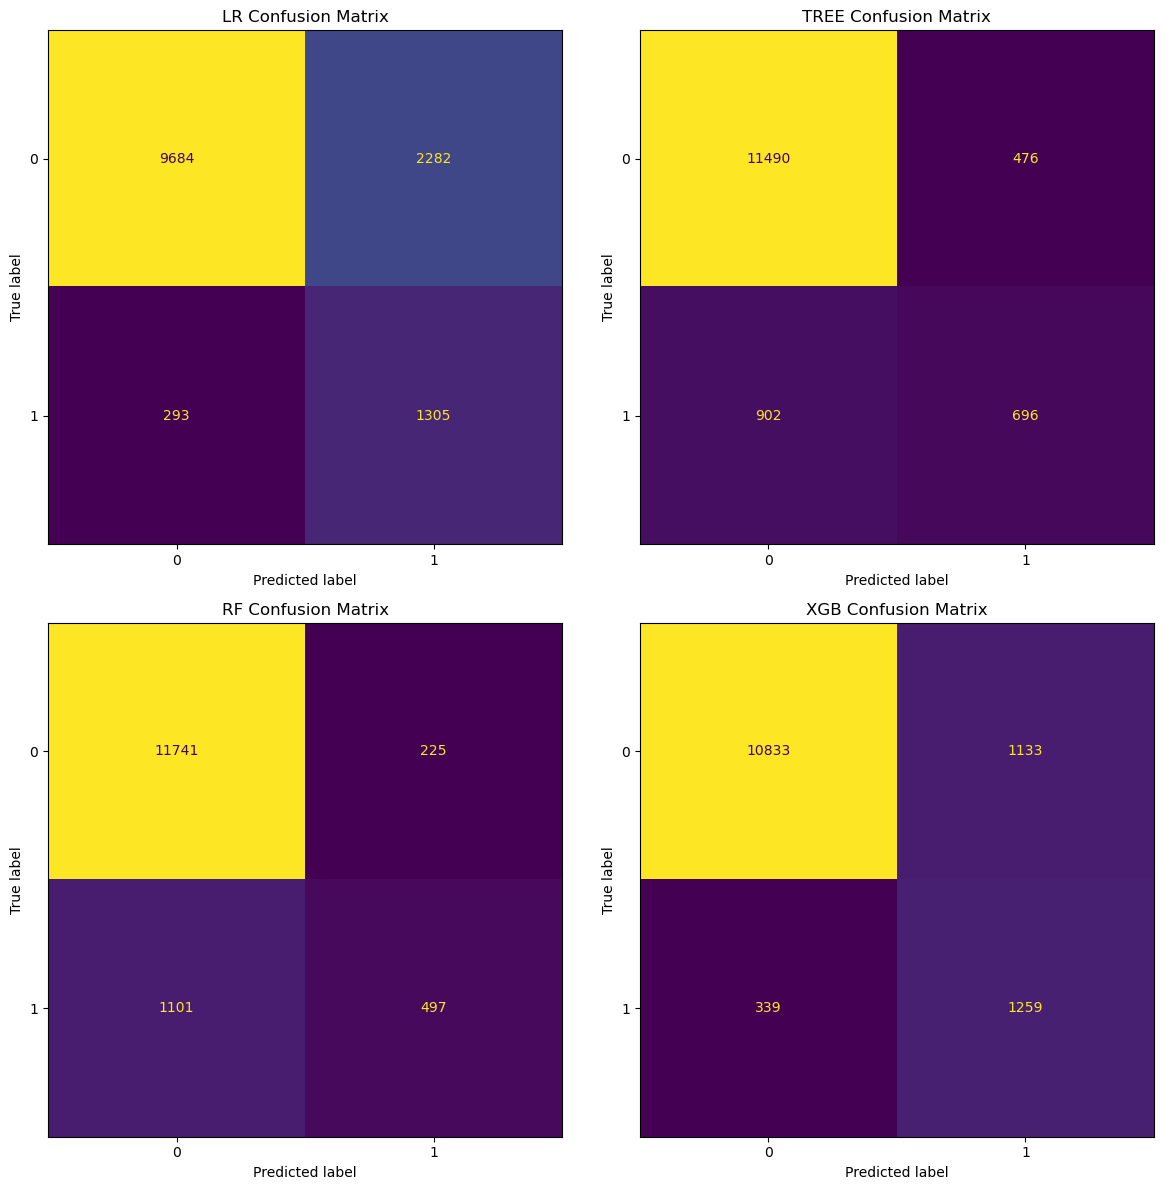

In [97]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ax, (model_name, res) in zip(axes, results.items()):
    pipeline = build_best_pipeline(model_name, res["best_params"])
    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)

    disp.plot(ax=ax, colorbar=False)
    ax.set_title(f"{model_name.upper()} Confusion Matrix")

plt.tight_layout()
plt.savefig("conf_mat.png", dpi=100, bbox_inches="tight")
plt.show()

In [94]:
xgb_pipeline = build_best_pipeline("xgb", results["xgb"]["best_params"])
xgb_pipeline.fit(X_train, y_train)
xgb_model = xgb_pipeline.named_steps["model"]
X_train_preprocessed = xgb_pipeline.named_steps["preprocess"].transform(X_train)

if hasattr(xgb_pipeline.named_steps["preprocess"], "get_feature_names_out"):
    feature_names = xgb_pipeline.named_steps["preprocess"].get_feature_names_out()
else:
    feature_names = X_train.columns

explainer = shap.Explainer(xgb_model, X_train_preprocessed, feature_names=feature_names)
shap_values = explainer(X_train_preprocessed)


100%|===================| 31641/31647 [19:48<00:00]        

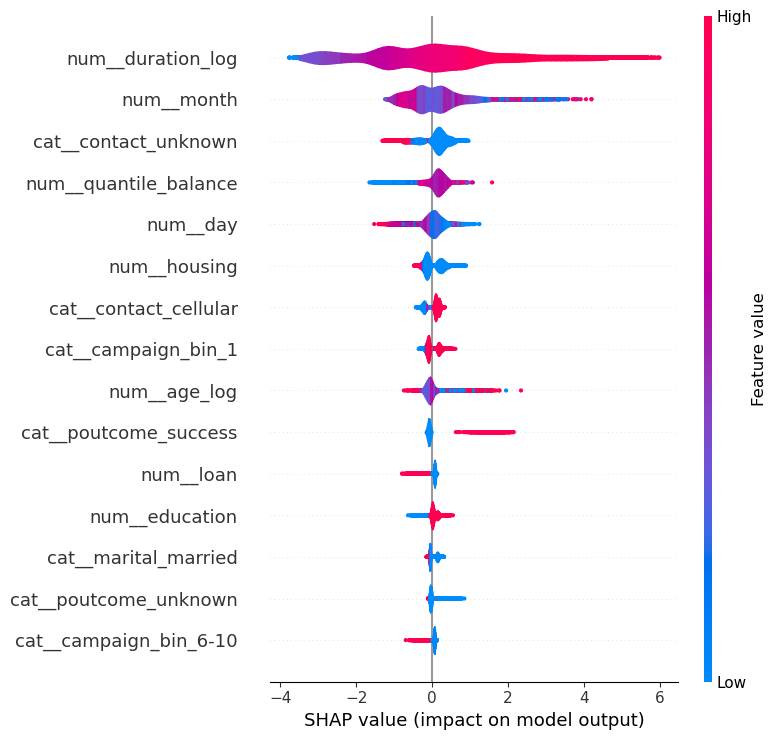

In [95]:
shap.summary_plot(shap_values, X_train_preprocessed, feature_names=feature_names, max_display=15, plot_type="violin", show=False)

plt.tight_layout()
plt.savefig("shap.png", dpi=100, bbox_inches="tight")
plt.show()